In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import os
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Merging Data from files with pixel info of annotated images

In [5]:
w_3 = pd.read_csv(r"C:\Users\Dell\Downloads\water_project\pixels_df_1.csv")
w_6_1= pd.read_csv(r"C:\Users\Dell\Downloads\water_project\pixels_df_2.csv")
w_6_2 = pd.read_csv(r"C:\Users\Dell\Downloads\water_project\pixels_df_3.csv")
# merge watershed 6
w_6 = pd.concat([w_6_1, w_6_2])

In [4]:
w_6.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
1,1403,1266,192,177,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
2,1403,1267,192,177,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
3,1403,1268,190,178,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
4,1403,1269,190,178,218,01/01/2019,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o


In [18]:
def wrangle_data(df):
    # remove duplicate RGB
    df = df.drop_duplicates()
    df["date"] = pd.to_datetime(df["date"])
    df["temperature"] = df.temperature.apply(lambda a: float(a[:-1]) if type(a) != float else np.nan)
    return df

def pick_samples(df):
    '''
    pick samples from each class with defined max class size
    '''
    sampled_df = df.head(1)
    max_class_size = 100
    for date in df.orig_name.unique():
        date_grouped = df[df.orig_name==date]
        nth = len(date_grouped)//max_class_size
        if nth==0:
            sampled_df = pd.concat([sampled_df,date_grouped])
        else:
            curr_group = date_grouped.iloc[::nth,:]
            sampled_df = pd.concat([sampled_df,curr_group])
    sampled_df.drop_duplicates(inplace=True)
    return sampled_df

def split_fit_basic_report(df):
    """
    Split dataset into training and test, fit model using default RCF parameters
    return model, prediction, feature_importances, X_train, X_test, y_train, y_test
    """
    X = df.drop('class',axis=1)
    y = df['class'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)
    rfc = RandomForestClassifier(random_state = 1)
    rfc.fit(X_train, y_train)
    # predict on test data
    rfc_pred = rfc.predict(X_test)
    print(classification_report(y_test,rfc_pred))
    feature_val = pd.DataFrame(rfc.feature_importances_, index = X_train.columns)
    print(feature_val.sort_values(0, ascending=False))
    return rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test

def plot_cm(y_test, rfc_pred):
    """
    plot confusion matrix of model predictions
    """
    p,ax = plt.subplots(figsize=(30, 20))

    ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred, ax=ax, colorbar=True)
    plt.show()


In [7]:
w_6 = wrangle_data(w_6)
w_3 = wrangle_data(w_3)

In [50]:
# merge watershed 6 and 3
merged = pd.concat([w_6,w_3])
merged = merged.drop_duplicates()
merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
1,1403,1266,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
2,1403,1267,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
3,1403,1268,190,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
4,1403,1269,190,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o


In [51]:
merged.shape

(10859075, 11)

In [188]:
merged.temperature = merged.temperature.fillna(method="ffill")
merged.dropna(inplace=True)

In [52]:
# save csv
merged.to_csv("merged.csv", index=False)

In [35]:
# make sample data set from merged data
sample_merged = pick_samples(merged)
sample_merged = sample_merged.drop_duplicates()
sample_merged.shape

(34176, 11)

In [4]:
sample_merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
1,1407,1294,186,175,215,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
2,1412,1290,194,183,223,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
3,1417,1286,188,180,219,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
4,1422,1282,184,178,216,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o


In [53]:
# save sample csv
sample_merged.to_csv("sample_merged.csv", index=False)

In [24]:
merged = pd.read_csv("merged.csv")
sample_merged = pd.read_csv("sample_merged.csv")

In [6]:
sample_merged.describe()

,x,y,R,G,B,temperature
count,34176.000000,34176.000000,34176.000000,34176.000000,34176.000000,23352.000000
mean,1229.135183,1729.401334,131.804658,121.490929,128.553517,35.247131
std,376.928844,327.383461,78.530751,79.800362,93.328862,12.430250
min,47.000000,1234.000000,0.000000,0.000000,0.000000,12.000000
25%,1036.000000,1439.000000,58.000000,47.000000,38.000000,28.000000
50%,1267.000000,1608.000000,125.000000,110.000000,104.000000,33.000000
75%,1489.000000,2074.000000,202.000000,194.000000,230.000000,41.000000
max,1997.000000,2336.000000,255.000000,255.000000,255.000000,98.000000


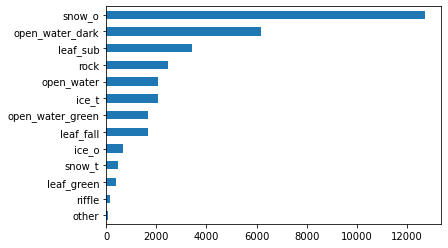

In [7]:
# distribution of classes in sample
# all classes are represented with imbalanced distribution
sample_merged["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

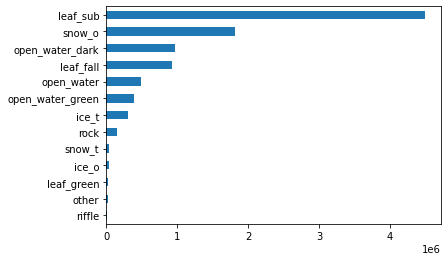

In [58]:
# watershed 6 distribution
w_6["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

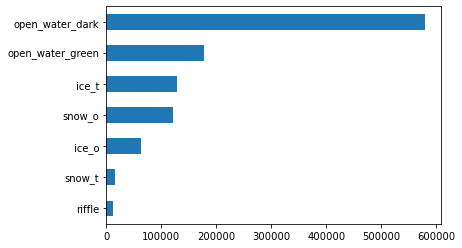

In [59]:
# watershed 3 distribution
w_3["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

## Train and Test on w6

In [12]:
# train and test on w6
w_6.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
3,1403,1268,190,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
6,1403,1271,189,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
7,1403,1272,190,179,219,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
8,1403,1273,191,180,220,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o


In [16]:
w_6.head().temperature.apply(lambda a:a[:-1])

0    35
1    35
2    35
3    35
4    35
Name: temperature, dtype: object

### Train only using RGB

In [13]:
w_6_train = w_6[["R","G","B", "class"]]


In [14]:
# imbalanced classes, is an issue
w_6_train["class"].value_counts()

leaf_fall           113695
leaf_sub             54657
rock                 33001
open_water           19778
ice_t                17787
snow_o               12429
leaf_green            8992
open_water_green      7516
open_water_dark       7277
other                 3628
riffle                3594
ice_o                 2353
snow_t                1841
Name: class, dtype: int64

In [15]:
X = w_6_train.drop('class',axis=1)
y = w_6_train['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)
# stratify - keeps the same proportion 

In [16]:
# fit model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [17]:
# predict on test data
rfc_pred = rfc.predict(X_test)
accuracy_score(y_test,rfc_pred)

0.6579421248796014

In [18]:
print(classification_report(y_test,rfc_pred))

                  precision    recall  f1-score   support

           ice_o       0.34      0.20      0.25      1177
           ice_t       0.59      0.71      0.64      8893
       leaf_fall       0.78      0.85      0.82     56847
      leaf_green       0.59      0.54      0.56      4496
        leaf_sub       0.57      0.51      0.54     27329
      open_water       0.52      0.50      0.51      9889
 open_water_dark       0.58      0.56      0.57      3639
open_water_green       0.46      0.40      0.43      3758
           other       0.31      0.12      0.17      1814
          riffle       0.36      0.28      0.31      1797
            rock       0.50      0.49      0.50     16501
          snow_o       0.82      0.86      0.84      6214
          snow_t       0.32      0.17      0.22       920

        accuracy                           0.66    143274
       macro avg       0.52      0.48      0.49    143274
    weighted avg       0.65      0.66      0.65    143274



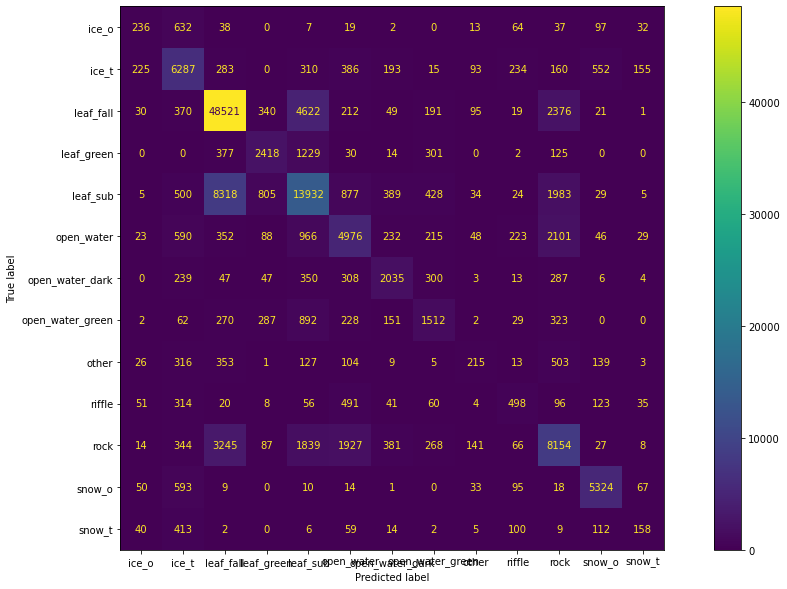

In [19]:
p,ax = plt.subplots(figsize=(18, 10))

ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred, ax=ax, colorbar=True)
plt.show()

In [20]:
pd.DataFrame(rfc.feature_importances_, index = X_train.columns)

,0
R,0.338431
G,0.278765
B,0.382804


Poor perforamnce, resample data and train using grid search

only using RGB

In [21]:
w_6.orig_name.value_counts()

Hbwtr_w6_20181013_120459.JPG    34063
Hbwtr_w6_20181014_120456.JPG    21922
Hbwtr_w6_20181016_120450.JPG    16894
Hbwtr_w6_20181021_115934.JPG    14114
Hbwtr_w6_20181023_115928.JPG    10771
                                ...  
Hbwtr_w6_20190309_120109.JPG        4
Hbwtr_w6_20190227_120103.JPG        3
Hbwtr_w6_20190328_120615.JPG        3
Hbwtr_w6_20191221_115858.JPG        3
Hbwtr_w6_20190313_120110.JPG        2
Name: orig_name, Length: 176, dtype: int64

In [22]:
# sample max=100 and min=2 points from all images
sampled_df = w_6.head(1)
max_class_size = 10
li = []
for date in w_6.orig_name.unique():
    date_grouped = w_6[w_6.orig_name==date]
    nth = len(date_grouped)//max_class_size
    if nth==0:
        sampled_df = pd.concat([sampled_df,date_grouped])
    else:
        curr_group = date_grouped.iloc[::nth,:]
        sampled_df = pd.concat([sampled_df,curr_group])
    li.append(nth)
    # print(nth, len(date_grouped))

In [23]:
sampled_df.shape, w_6.shape

((1912, 11), (286548, 11))

imbalanced class, issue

In [55]:
# train split resampled

df_1 = sampled_df[["R","G","B", "class"]]
X = df_1.drop('class',axis=1)
y = df_1['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1, stratify=y)

In [56]:
# run them default
# fit model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
# predict on test data
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))

                  precision    recall  f1-score   support

           ice_o       0.00      0.00      0.00         9
           ice_t       0.47      0.45      0.46        69
       leaf_fall       0.59      0.63      0.61       103
      leaf_green       0.65      0.88      0.75        25
        leaf_sub       0.39      0.33      0.36        90
      open_water       0.36      0.38      0.37        52
 open_water_dark       0.60      0.64      0.62        39
open_water_green       0.00      0.00      0.00         7
           other       0.00      0.00      0.00        10
          riffle       1.00      0.33      0.50         6
            rock       0.40      0.45      0.42       103
          snow_o       0.88      0.94      0.90       233
          snow_t       0.00      0.00      0.00        19

        accuracy                           0.60       765
       macro avg       0.41      0.39      0.38       765
    weighted avg       0.57      0.60      0.58       765



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 100-> 0.65
# 1,000 ->0.63
# 10,000->0.65

 Now, grid search

In [51]:
n_cpus = os.cpu_count()
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 10, cv = 5,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [52]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=7,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy', verbose=3)

In [53]:
rf_random.best_params_

{'n_estimators': 1135,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'criterion': 'gini',
 'bootstrap': True}

In [57]:
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

0.9616390584132519
0.6222222222222222


In [60]:
# build up on the randomized cv search and find better params

param_grid = {
    'n_estimators': np.linspace(1100, 1300, 5, dtype = int),
    'max_depth': [8,10,12,15],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}

# Base model
rf_grid = RandomForestClassifier(criterion = 'gini', bootstrap = True)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)


In [61]:
grid_rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=7,
             param_grid={'max_depth': [8, 10, 12, 15],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': array([1100, 1150, 1200, 1250, 1300])},
             verbose=3)

In [62]:
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1100}

In [64]:
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

1.0
0.6130718954248366


In [ ]:
pd.DataFrame(best_rf_grid.feature_importances_, index = X_train.columns)

Max accuracy found 62%.

### Train using RGB, x, y and temp on W6

In [11]:
w_6.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
1,1403,1266,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
2,1403,1267,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
3,1403,1268,190,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
4,1403,1269,190,178,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o


In [7]:
sample_merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
1,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
2,1407,1294,186,175,215,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
3,1412,1290,194,183,223,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
4,1417,1286,188,180,219,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o


In [12]:
train_w6_2 = pick_samples(w_6)
train_w6_2 = train_w6_2[["x","y","R","G","B", "temperature", "class"]]
train_w6_2.shape

(26603, 7)

In [11]:
sample_merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
1,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
2,1407,1294,186,175,215,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
3,1412,1290,194,183,223,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
4,1417,1286,188,180,219,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o


In [31]:
sampled_df.shape

(26603, 11)

In [13]:
train_w6_2.shape

(26603, 7)

In [26]:
train_w6_2=train_w6_2.dropna()
rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test = split_fit_basic_report(train_w6_2)

                  precision    recall  f1-score   support

           ice_o       0.89      0.57      0.70        54
           ice_t       0.81      0.79      0.80       310
       leaf_fall       0.87      0.76      0.81       365
      leaf_green       0.95      0.78      0.86        77
        leaf_sub       0.80      0.88      0.84       577
      open_water       0.79      0.81      0.80       412
 open_water_dark       0.86      0.93      0.89       487
open_water_green       0.83      0.57      0.68        70
           other       1.00      0.29      0.45        17
          riffle       0.73      0.42      0.53        19
            rock       0.89      0.90      0.90       591
          snow_o       0.98      0.99      0.98      2232
          snow_t       0.90      0.66      0.76       106

        accuracy                           0.90      5317
       macro avg       0.87      0.72      0.77      5317
    weighted avg       0.90      0.90      0.90      5317

           

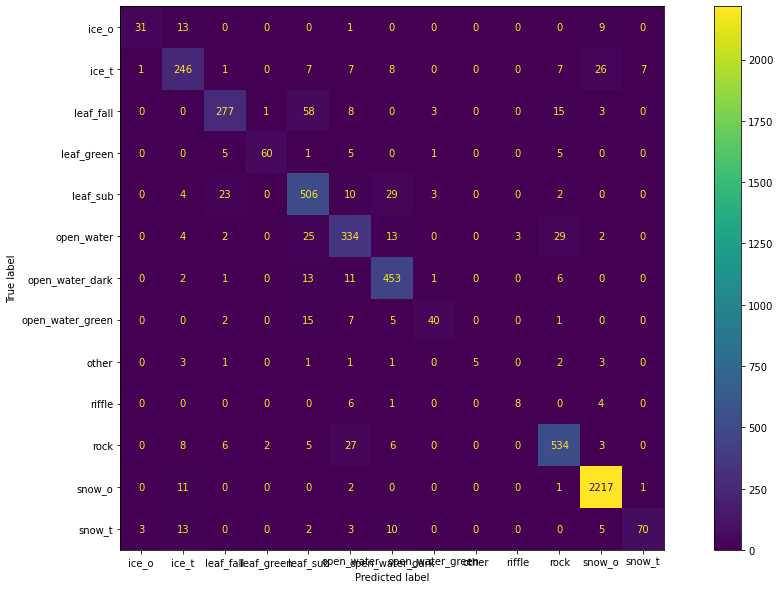

In [18]:
plot_cm(y_test, rfc_pred)

 Max accuracy found - 0.9
 
 Use Grid search for best paramters

In [28]:
n_cpus = os.cpu_count()
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 50, cv = 3,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [29]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=7,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy', verbose=4)

In [30]:
rf_random.best_params_

{'n_estimators': 2378,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 100,
 'criterion': 'gini',
 'bootstrap': False}

In [32]:
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

1.0
0.902388564980252


In [33]:
# build up on the randomized cv search and find better params

param_grid = {
    'n_estimators': np.linspace(2350, 2400, 5, dtype = int),
    'max_depth': [50,70,100,110, 120],
    'min_samples_split': [4,5,6],
    'min_samples_leaf': [1, 2]
}

# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = True)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)


In [ ]:
grid_rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [62]:
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1100}

In [64]:
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

1.0
0.6130718954248366


In [ ]:
pd.DataFrame(best_rf_grid.feature_importances_, index = X_train.columns)

## Tran and test using W3

### Train only using RGB

In [78]:
w_3["date"] = pd.to_datetime(w_3["date"])
w_3 = w_3.dropna()
w_3 = w_3.drop_duplicates()
w_3.shape

(813257, 11)

In [84]:
w_3 = w_3[["R","G","B", "class"]]
w_3

,R,G,B,class
0,30,32,47,open_water_dark
1,20,22,37,open_water_dark
2,15,17,32,open_water_dark
3,16,18,33,open_water_dark
4,18,21,30,open_water_dark
...,...,...,...,...
1102364,131,132,98,open_water_green
1102365,122,124,85,open_water_green
1102366,135,138,95,open_water_green
1102367,154,157,110,open_water_green


In [85]:
X = w_3.drop('class',axis=1)
y = w_3['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


In [86]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [87]:
rfc_pred = rfc.predict(X_test)


In [88]:
print(classification_report(y_test,rfc_pred))


                  precision    recall  f1-score   support

           ice_o       0.84      0.89      0.87     19334
           ice_t       0.78      0.74      0.76     28896
 open_water_dark       0.83      0.90      0.86    118873
open_water_green       0.77      0.62      0.69     45118
          riffle       0.79      0.80      0.80      4009
          snow_o       0.96      0.98      0.97     23097
          snow_t       0.68      0.51      0.58      4651

        accuracy                           0.83    243978
       macro avg       0.81      0.78      0.79    243978
    weighted avg       0.82      0.83      0.82    243978



In [30]:
w_6.orig_name.value_counts()

Hbwtr_w6_20181013_120459.JPG    34063
Hbwtr_w6_20181014_120456.JPG    21922
Hbwtr_w6_20181016_120450.JPG    16894
Hbwtr_w6_20181021_115934.JPG    14114
Hbwtr_w6_20181023_115928.JPG    10771
                                ...  
Hbwtr_w6_20190309_120109.JPG        4
Hbwtr_w6_20190227_120103.JPG        3
Hbwtr_w6_20190328_120615.JPG        3
Hbwtr_w6_20191221_115858.JPG        3
Hbwtr_w6_20190313_120110.JPG        2
Name: orig_name, Length: 176, dtype: int64

In [83]:
sampled_df.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35F,snow_o
16153,1094,1352,31,18,35,2019-01-02,11:59:44,Hbwtr_w6_20190102_115944.JPG,w6,26F,open_water_dark
84181,976,1369,57,38,42,2019-01-07,11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21F,open_water_dark
98474,1128,1499,163,158,199,2019-01-08,12:04:25,Hbwtr_w6_20190108_120425.JPG,w6,23F,snow_o
126166,1067,1400,202,190,228,2019-01-10,11:59:18,Hbwtr_w6_20190110_115918.JPG,w6,26F,snow_o


In [31]:
df_1  = w_6[["R","G","B", "class"]]
df_1= df_1.fillna(value=np.nan)
df_1 = df_1.dropna()
# no x and y
df_1 = df_1.drop_duplicates()

In [28]:
# Train test split
from sklearn.model_selection import train_test_split
X = df_1.drop('class',axis=1)
y = df_1['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70)

In [29]:
X_train.shape

(242355, 3)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

rfc = RandomForestClassifier(n_estimators=100,
                            # max_depth = 8,
                            max_samples = 0.5)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.5)

In [50]:
# predict on test data
rfc_pred = rfc.predict(X_test)

In [51]:
print(classification_report(y_test,rfc_pred))

                  precision    recall  f1-score   support

           ice_o       0.11      0.09      0.10      6475
           ice_t       0.26      0.29      0.27     32756
       leaf_fall       0.47      0.50      0.48    167040
      leaf_green       0.16      0.10      0.12      9995
        leaf_sub       0.31      0.34      0.33    160969
      open_water       0.09      0.09      0.09     45820
 open_water_dark       0.08      0.07      0.07     21134
open_water_green       0.05      0.04      0.05     30847
           other       0.10      0.06      0.07     10220
          riffle       0.26      0.20      0.23      7805
            rock       0.17      0.16      0.17     46946
          snow_o       0.56      0.63      0.59     15179
          snow_t       0.06      0.05      0.06     10311

        accuracy                           0.31    565497
       macro avg       0.21      0.20      0.20    565497
    weighted avg       0.30      0.31      0.30    565497



In [18]:
cm = confusion_matrix(y_test,rfc_pred)

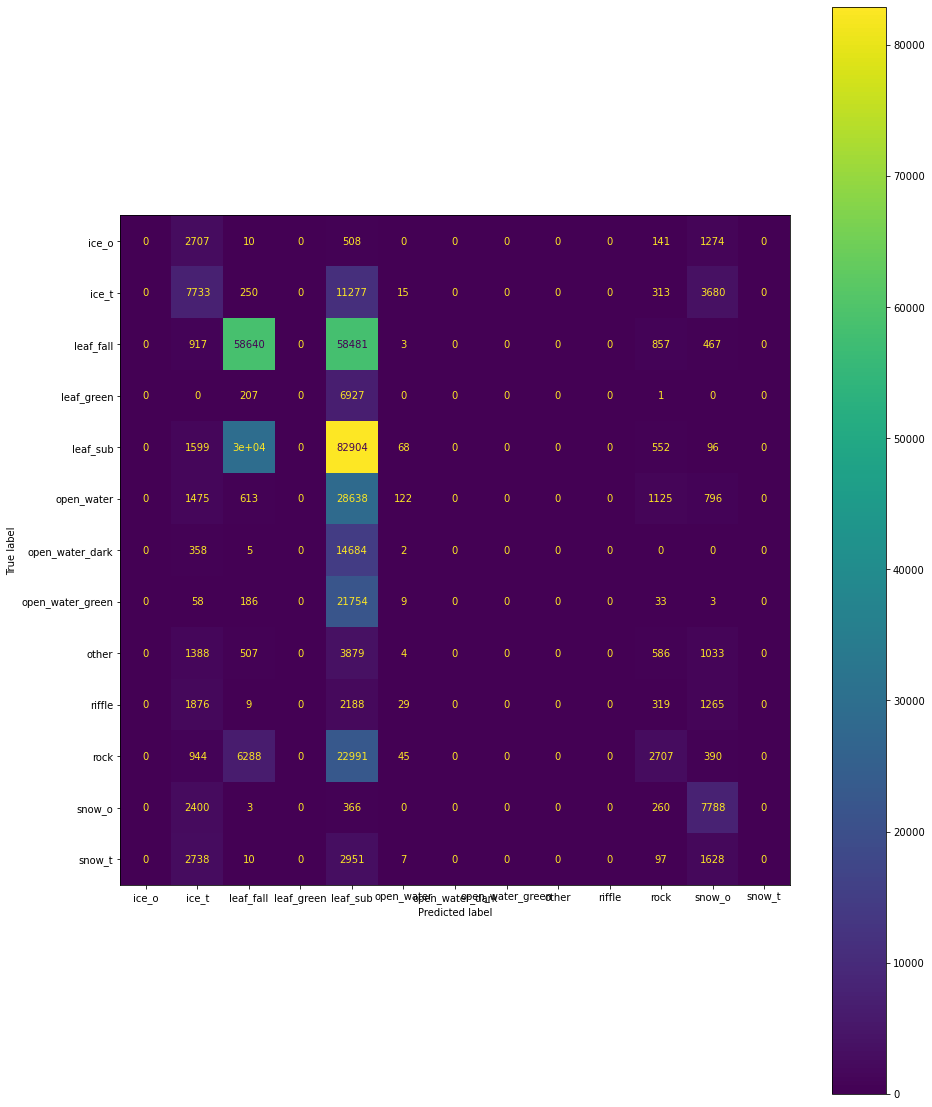

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
p,ax = plt.subplots(figsize=(15, 20))

ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred, ax=ax)
plt.show()

In [59]:
# train on w6_1 and try
df_2  = w_6_1[["x", "y","R","G","B", "class"]]
df_2= df_2.fillna(value=np.nan)
df_2 = df_2.dropna()
# no x and y
df_2 = df_2.drop_duplicates()

In [60]:
X = df_2.drop('class',axis=1)
y = df_2['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
rfc = RandomForestClassifier(n_estimators=100)
                            # max_depth = 8,
                            # max_samples = 0.5)
rfc.fit(X_train, y_train)


RandomForestClassifier()

In [61]:
rfc_pred = rfc.predict(X_test)
print(classification_report(y_test,rfc_pred))

                  precision    recall  f1-score   support

           ice_o       0.99      0.98      0.99      3342
           ice_t       0.99      0.98      0.98      9793
       leaf_fall       0.99      0.98      0.98     16595
      leaf_green       0.99      0.99      0.99      6018
        leaf_sub       0.98      0.97      0.97      7580
      open_water       0.97      0.98      0.98     50395
 open_water_dark       0.98      0.98      0.98     26924
open_water_green       0.97      0.96      0.96       645
           other       0.99      0.87      0.93      1338
          riffle       0.98      0.89      0.93      1781
            rock       0.98      0.98      0.98     47625
          snow_o       1.00      1.00      1.00    345715
          snow_t       0.99      0.97      0.98      2386

        accuracy                           0.99    520137
       macro avg       0.99      0.96      0.97    520137
    weighted avg       0.99      0.99      0.99    520137



In [64]:
df_3 =  w_6_2[["x", "y","R","G","B", "class"]]
df_3= df_3.fillna(value=np.nan)
df_3 = df_3.dropna()
# no x and y
df_3 = df_3.drop_duplicates()
X_2 = df_2.drop('class',axis=1)
y_2 = df_2['class']
rfc_pred_2 = rfc.predict(X_2)


In [ ]:
print(classification_report(y_2,rfc_pred_2))

In [ ]:
# classes choose-condensing , pixels sampling, ice coverage

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Train on merged file

In [5]:
sample_merged.temperature

0        35.0
1        35.0
2        35.0
3        35.0
4        35.0
         ... 
34171    33.0
34172    33.0
34173    33.0
34174    33.0
34175    33.0
Name: temperature, Length: 34176, dtype: float64

In [13]:
sample_merged[sample_merged.isnull().any(axis=1)].shape

(10910, 11)

### Train using features X,Y, RGB, Temperature

                  precision    recall  f1-score   support

           ice_o       0.94      0.85      0.90       191
           ice_t       0.82      0.80      0.81       516
       leaf_fall       0.92      0.82      0.87       365
      leaf_green       0.91      0.88      0.89        77
        leaf_sub       0.82      0.82      0.82       577
      open_water       0.80      0.79      0.80       412
 open_water_dark       0.84      0.93      0.88      1250
open_water_green       0.84      0.72      0.77       421
           other       1.00      0.29      0.45        17
          riffle       0.97      0.72      0.83        47
            rock       0.90      0.94      0.92       591
          snow_o       0.98      1.00      0.99      2383
          snow_t       0.92      0.64      0.76       133

        accuracy                           0.90      6980
       macro avg       0.90      0.79      0.82      6980
    weighted avg       0.90      0.90      0.89      6980

           

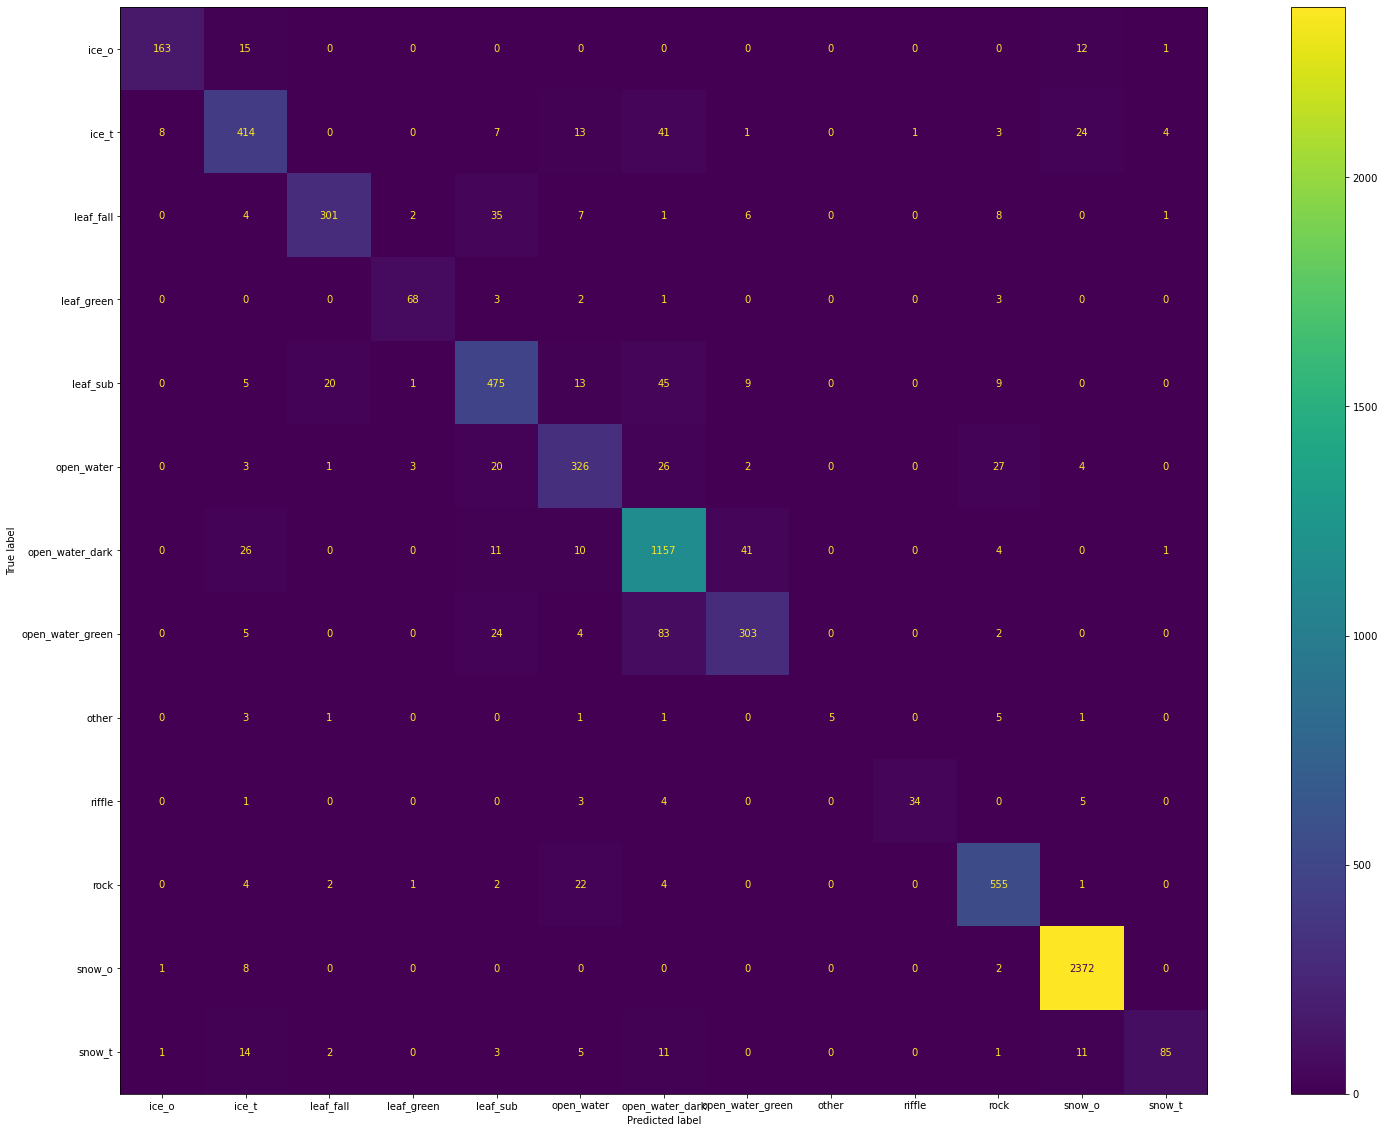

In [6]:
# using x,y,RGB, temp
train_merged = sample_merged[["x","y","R","G","B", "temperature", "class"]]
train_merged.dropna(inplace=True)
rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test = split_fit_basic_report(train_merged)
plot_cm(y_test, rfc_pred)

Use grid search to select best estimators

In [7]:
## Create Randomized search CV to find estimates closer to the best paramaters

n_cpus = os.cpu_count()
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 10, cv = 5,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [8]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=63,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy')

In [9]:
# best parameters found using random search
rf_random.best_params_

{'n_estimators': 928,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': False}

In [43]:
# result of random search cv
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

0.9885791477342503
0.8888252148997134


Building up on the results of randomized cv search, find better params using grid search cv


In [38]:
param_grid = {
    'n_estimators': np.linspace(900, 950, 10, dtype = int),
    'max_depth': [30, 40, 50, 60],
    'min_samples_split': [8, 10,12],
    'min_samples_leaf': [1, 2]
}
# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = False)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)


In [39]:
grid_rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=8, n_estimators=900;, score=0.877 total time= 1.0min
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=950;, score=0.874 total time= 1.1min
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=927;, score=0.878 total time= 1.1min
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=944;, score=0.872 total time= 1.3min
[CV 1/5] END max_depth=40, min_samples_leaf=1, min_samples_split=8, n_estimators=922;, score=0.865 total time= 1.2min
[CV 3/5] END max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=950;, score=0.872 total time= 1.0min
[CV 2/5] END max_depth=40, min_samples_leaf=2, min_samples_split=8, n_estimators=911;, score=0.879 total time=  47.6s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=8, n_estimators=922;, score=0.863 total ti

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy'),
             n_jobs=63,
             param_grid={'max_depth': [30, 40, 50, 60],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': array([900, 905, 911, 916, 922, 927, 933, 938, 944, 950])},
             verbose=3)

In [47]:
# best estimators of grid search cv
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 950}

In [51]:
# results of grid search cv
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

0.9988947562323468
0.8961318051575932


In [55]:
# feature importances of our input features
pd.DataFrame(best_rf_grid.feature_importances_, index = ["x","y","R","G","B","temperature"], columns=["%_imp"]).sort_values("%_imp", 
                                                                                                                           ascending=False)

,%_imp
B,0.291604
R,0.164986
y,0.163910
G,0.151743
temperature,0.113986
x,0.113770


## Final Model
Use these additional features to train our model : Year, Week of day, Season variables

In [52]:
# add year, week of the year, month, and season features
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)
sample_merged.date = pd.to_datetime(sample_merged.date)
sample_merged.time = pd.to_datetime(sample_merged.time)
sample_merged["year"] = sample_merged.date.dt.year
sample_merged["week"] =sample_merged.date.dt.isocalendar().week
sample_merged["month"] = sample_merged.date.dt.month
sample_merged["season"] = sample_merged.date.apply(lambda x: get_season(x))

from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(sample_merged[['season']]).toarray(),
                         columns = ["season_autumn", "season_spring", "season_winter"])

sample_merged = sample_merged.join(encoder_df)
sample_merged.to_csv("sample_merged_date.csv", index=False)

In [6]:
sample_merged=pd.read_csv("sample_merged_date.csv")

In [7]:
sample_merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class,year,week,month,season,season_autumn,season_spring,season_winter
0,1403,1265,192,177,218,2019-01-01 00:00:00,2022-07-17 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,winter,0.0,0.0,1.0
1,1407,1294,186,175,215,2019-01-01 00:00:00,2022-07-17 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,winter,0.0,0.0,1.0
2,1412,1290,194,183,223,2019-01-01 00:00:00,2022-07-17 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,winter,0.0,0.0,1.0
3,1417,1286,188,180,219,2019-01-01 00:00:00,2022-07-17 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,winter,0.0,0.0,1.0
4,1422,1282,184,178,216,2019-01-01 00:00:00,2022-07-17 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,winter,0.0,0.0,1.0


                  precision    recall  f1-score   support

           ice_o       0.97      0.93      0.95       191
           ice_t       0.91      0.92      0.92       516
       leaf_fall       0.94      0.91      0.92       365
      leaf_green       0.96      0.95      0.95        77
        leaf_sub       0.90      0.95      0.92       577
      open_water       0.92      0.92      0.92       412
 open_water_dark       0.93      0.96      0.95      1250
open_water_green       0.92      0.83      0.88       421
           other       1.00      0.35      0.52        17
          riffle       0.91      0.87      0.89        47
            rock       0.96      0.96      0.96       591
          snow_o       0.99      1.00      1.00      2383
          snow_t       0.97      0.88      0.92       133

        accuracy                           0.95      6980
       macro avg       0.95      0.88      0.90      6980
    weighted avg       0.95      0.95      0.95      6980

           

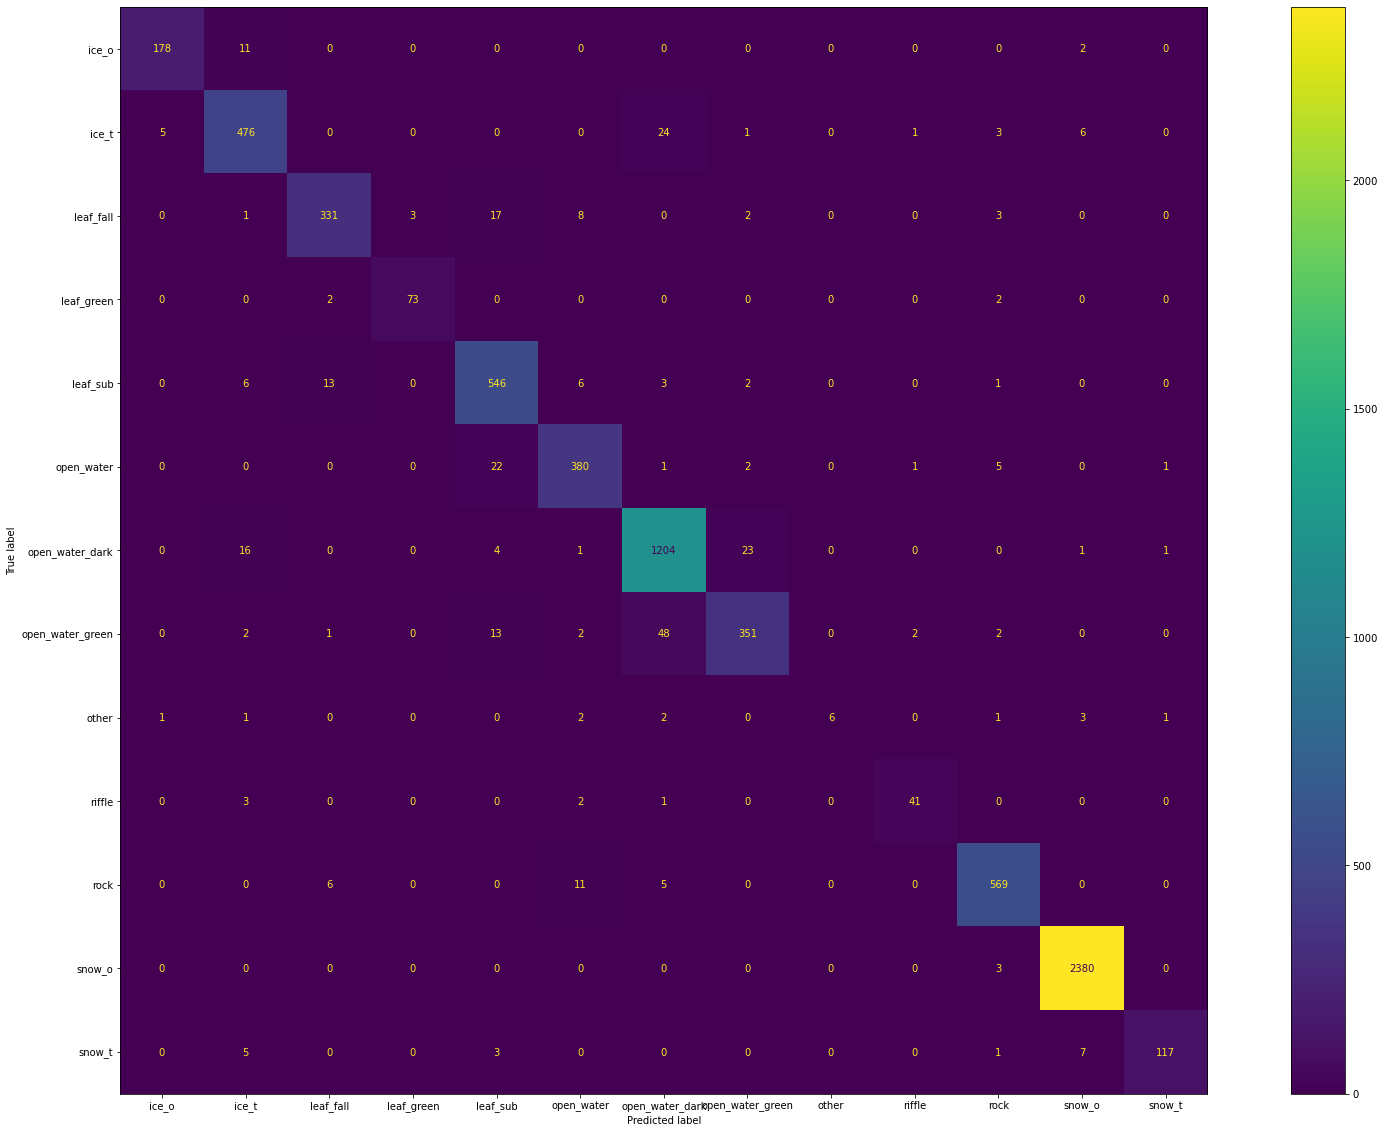

In [11]:
# model using RF default parameters
train_merged_2 = sample_merged[
    ['x', 'y', 'R', 'G', 'B',  'temperature', 'class', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']]
train_merged_2.dropna(inplace=True)
rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test = split_fit_basic_report(train_merged_2)
plot_cm(y_test, rfc_pred)

Use grid search to select best estimators and improve accuracy

In [12]:
n_cpus = os.cpu_count()
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [80]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=75, min_samples_leaf=2, min_samples_split=20, n_estimators=307;, score=0.901 total time=   9.7s
[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.912 total time= 1.3min
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=75, min_samples_leaf=2, min_samples_split=20, n_estimators=307;, score=0.905 total time=   9.4s
[CV 2/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.912 total time= 1.3min
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=307;, score=0.931 total time=   9.5s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.906 total time= 1.3min
[CV 1/

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=63,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy', verbose=3)

In [82]:
rf_random.best_params_

{'n_estimators': 2378,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 75,
 'criterion': 'entropy',
 'bootstrap': False}

In [ ]:
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

In [13]:
# build up on the randomized cv search and find better params
param_grid = {
    'n_estimators': np.linspace(2300, 2400, 10, dtype = int),
    'max_depth': [30, 55, 75],
    'min_samples_split': [4,5],
    'min_samples_leaf': [1, 2]
}
# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = False)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)

In [14]:
grid_rf_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy'),
             n_jobs=63,
             param_grid={'max_depth': [30, 55, 75], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [4, 5],
                         'n_estimators': array([2300, 2311, 2322, 2333, 2344, 2355, 2366, 2377, 2388, 2400])})

In [118]:
best_rf_grid_final = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 2355}

In [17]:
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

1.0
0.9594555873925501


In [119]:
pd.DataFrame(best_rf_grid_final.feature_importances_, index = X_train.columns, columns=["%_imp"]).sort_values("%_imp",ascending=False)

,%_imp
B,0.212463
G,0.118422
R,0.116707
week,0.110567
y,0.102641
x,0.071066
year,0.071063
temperature,0.068147
month,0.062842
season_winter,0.037524


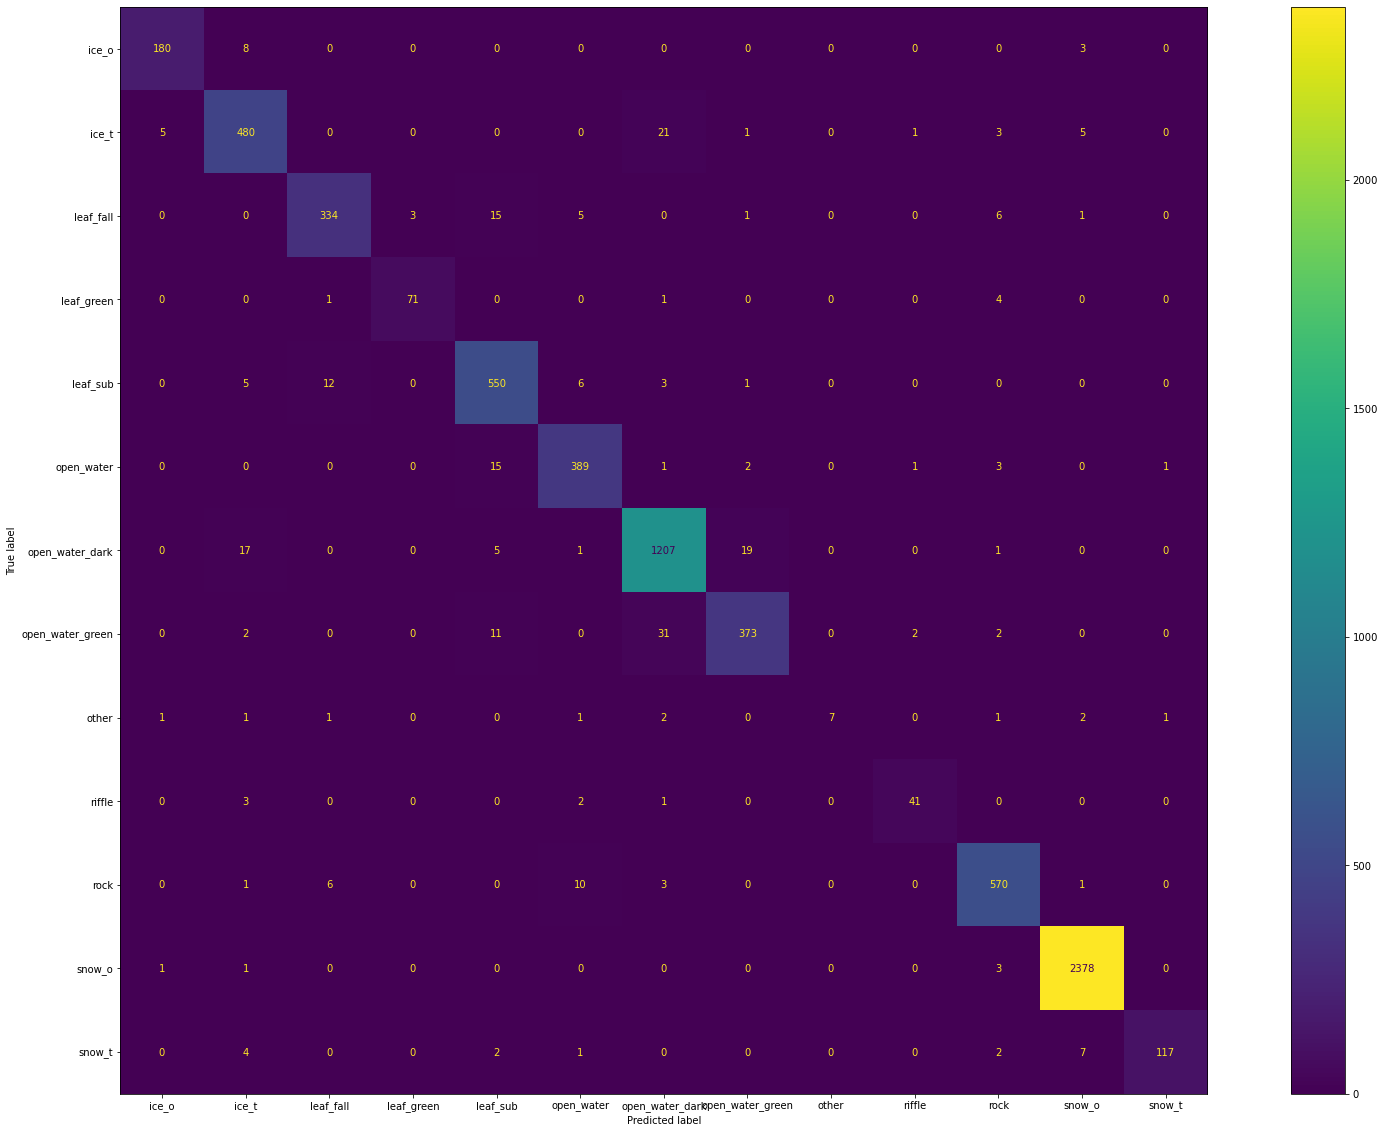

In [45]:
rf_pred = best_rf_grid_2.predict(X_test)
plot_cm(y_test, rf_pred)

In [46]:
print(classification_report(y_test,rf_pred))


                  precision    recall  f1-score   support

           ice_o       0.96      0.94      0.95       191
           ice_t       0.92      0.93      0.92       516
       leaf_fall       0.94      0.92      0.93       365
      leaf_green       0.96      0.92      0.94        77
        leaf_sub       0.92      0.95      0.94       577
      open_water       0.94      0.94      0.94       412
 open_water_dark       0.95      0.97      0.96      1250
open_water_green       0.94      0.89      0.91       421
           other       1.00      0.41      0.58        17
          riffle       0.91      0.87      0.89        47
            rock       0.96      0.96      0.96       591
          snow_o       0.99      1.00      0.99      2383
          snow_t       0.98      0.88      0.93       133

        accuracy                           0.96      6980
       macro avg       0.95      0.89      0.91      6980
    weighted avg       0.96      0.96      0.96      6980



In [ ]:
# final accuracy of 96%

In [16]:
# data points that are not in sampled data
ind_array = np.setdiff1d(merged.index,sample_merged.index)

In [19]:
test_sample = pick_samples(merged.iloc[ind_array])

In [26]:
test_sample.describe()

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
count,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000,23064.000000
mean,1216.258541,1740.998916,128.318548,118.011056,125.427593,35.297086,2019.002341,25.248006,6.285727,0.383455,0.109651,0.506894
std,384.506682,327.868262,76.502371,77.504077,90.202387,12.480835,0.691681,20.310771,4.668785,0.486238,0.312462,0.499963
min,59.000000,1234.000000,0.000000,0.000000,0.000000,12.000000,2018.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1025.000000,1446.000000,57.000000,46.000000,39.000000,28.000000,2019.000000,6.000000,2.000000,0.000000,0.000000,0.000000
50%,1258.000000,1626.000000,123.000000,109.000000,103.000000,33.000000,2019.000000,14.000000,4.000000,0.000000,0.000000,1.000000
75%,1480.000000,2080.000000,195.000000,187.000000,222.000000,41.000000,2019.000000,47.000000,11.000000,1.000000,0.000000,1.000000
max,1997.000000,2336.000000,255.000000,255.000000,255.000000,98.000000,2020.000000,52.000000,12.000000,1.000000,1.000000,1.000000


In [21]:
test_sample.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
34176,1245,1546,195,184,224,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34293,1249,1535,200,193,227,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34410,1253,1524,201,193,230,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34527,1256,1545,197,186,226,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34644,1260,1534,197,189,230,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o


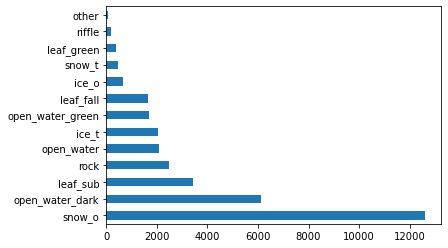

In [48]:
test_sample["class"].value_counts().plot(kind="barh");

In [49]:
sample_merged.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
0,1403,1265,192,177,218,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
1,1407,1294,186,175,215,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
2,1412,1290,194,183,223,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
3,1417,1286,188,180,219,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o
4,1422,1282,184,178,216,2019-01-01,11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o


In [51]:
test_sample.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
34176,1245,1546,195,184,224,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34293,1249,1535,200,193,227,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34410,1253,1524,201,193,230,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34527,1256,1545,197,186,226,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o
34644,1260,1534,197,189,230,2019-01-03,11:59:41,Hbwtr_w6_20190103_115941.JPG,w6,NaN,snow_o


In [22]:
# add year, week of the year, month, and season features
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)
test_sample.date = pd.to_datetime(test_sample.date)
test_sample.time = pd.to_datetime(test_sample.time)
test_sample["year"] = test_sample.date.dt.year
test_sample["week"] =test_sample.date.dt.isocalendar().week
test_sample["month"] = test_sample.date.dt.month
test_sample["season"] = test_sample.date.apply(lambda x: get_season(x))

from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(test_sample[['season']]).toarray(),
                         columns = ["season_autumn", "season_spring", "season_winter"])

# test_sample = test_sample.join(encoder_df)

In [23]:
test_sample["season_autumn" ] = encoder_df["season_autumn"].values
test_sample["season_spring" ] = encoder_df["season_spring"].values
test_sample["season_winter" ] = encoder_df["season_winter"].values
test_sample.dropna(inplace=True)
test_sample.drop_duplicates(inplace=True)
test_sample_copy = test_sample.copy()
test_sample.to_csv("test_sample.csv", index=False)

In [24]:
test_sample.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class,year,week,month,season,season_autumn,season_spring,season_winter
84146,974,1368,55,36,42,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84289,982,1375,50,31,35,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84432,990,1382,50,35,40,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84575,1065,1355,56,33,43,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84718,1070,1363,49,36,46,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0


In [25]:
test_sample = test_sample[
    ['x', 'y', 'R', 'G', 'B',  'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter',"class"]]
test_sample_features=test_sample.drop("class", axis=1)
test_sample_labels =test_sample["class"]

In [28]:
sample_predict = model.predict(test_sample_features)

In [29]:
print(classification_report(test_sample_labels,sample_predict))


                  precision    recall  f1-score   support

           ice_o       0.99      0.98      0.99       636
           ice_t       0.98      0.98      0.98      1702
       leaf_fall       0.98      0.97      0.98      1217
      leaf_green       0.99      0.98      0.98       256
        leaf_sub       0.98      0.99      0.98      1922
      open_water       0.98      0.98      0.98      1372
 open_water_dark       0.98      0.99      0.99      4098
open_water_green       0.98      0.97      0.97      1405
           other       1.00      0.83      0.91        58
          riffle       0.97      0.96      0.97       158
            rock       0.99      0.99      0.99      1969
          snow_o       1.00      1.00      1.00      7829
          snow_t       1.00      0.96      0.98       442

        accuracy                           0.99     23064
       macro avg       0.99      0.97      0.98     23064
    weighted avg       0.99      0.99      0.99     23064



In [8]:
# save final model
from joblib import dump, load
# dump(best_rf_grid_final, "model.joblib")

In [9]:
model= load("model.joblib")

In [11]:
tt = sample_merged[
    ['x', 'y', 'R', 'G', 'B',  'temperature', 'class', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']]
tt.dropna(inplace=True)

In [12]:
l =tt.drop("class", axis=1)
t = tt["class"]

In [14]:
p = model.predict(l)
p

array(['snow_o', 'snow_o', 'snow_o', ..., 'open_water_green',
       'open_water_green', 'open_water_green'], dtype=object)

In [ ]:
print(classification_report(t, p))

                  precision    recall  f1-score   support

           ice_o       0.99      0.98      0.99       636
           ice_t       0.98      0.98      0.98      1719
       leaf_fall       0.98      0.97      0.98      1217
      leaf_green       0.99      0.98      0.98       256
        leaf_sub       0.98      0.99      0.98      1922
      open_water       0.98      0.98      0.98      1372
 open_water_dark       0.98      0.99      0.99      4167
open_water_green       0.98      0.97      0.97      1405
           other       1.00      0.83      0.91        58
          riffle       0.97      0.96      0.97       158
            rock       0.99      0.99      0.99      1969
          snow_o       1.00      1.00      1.00      7945
          snow_t       1.00      0.96      0.98       442

        accuracy                           0.99     23266
       macro avg       0.99      0.97      0.98     23266
    weighted avg       0.99      0.99      0.99     23266



In [124]:
# sample image prediction

In [173]:
sample_merged.head()[li]

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
0,1403,1265,192,177,218,35.0,2019,1,1,0.0,0.0,1.0
1,1407,1294,186,175,215,35.0,2019,1,1,0.0,0.0,1.0
2,1412,1290,194,183,223,35.0,2019,1,1,0.0,0.0,1.0
3,1417,1286,188,180,219,35.0,2019,1,1,0.0,0.0,1.0
4,1422,1282,184,178,216,35.0,2019,1,1,0.0,0.0,1.0


In [37]:
test_sample_copy.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class,year,week,month,season,season_autumn,season_spring,season_winter
84146,974,1368,55,36,42,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84289,982,1375,50,31,35,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84432,990,1382,50,35,40,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84575,1065,1355,56,33,43,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84718,1070,1363,49,36,46,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0


In [50]:
test_sample.head().columns

Index(['x', 'y', 'R', 'G', 'B', 'temperature', 'class', 'year', 'week',
       'month', 'season_autumn', 'season_spring', 'season_winter'],
      dtype='object')

In [30]:
from PIL import Image

In [48]:
file = "Hbwtr_w6_20190224_120101.JPG"

In [49]:
img= np.asarray(Image.open("invert_"+file))

In [34]:
%matplotlib widget

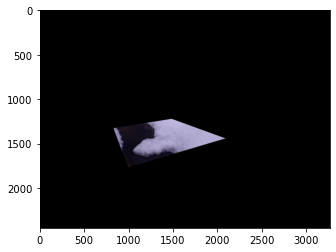

In [113]:
plt.imshow(img)

In [36]:
img.shape

(2448, 3264, 3)

In [37]:
img[1500,1400,:]

array([204, 198, 236], dtype=uint8)

In [39]:
img[1500,1400,:]

array([204, 198, 236], dtype=uint8)

In [40]:
t = 33.0
year =2019
w=8
m = 2
a,s,wt = 0,0,1

In [41]:
x,y = 1442, 1500
r,g,b = img[y,x,:]

In [45]:
ss = test_sample.head(0).drop(columns="class")
ss.loc[len(ss)]  = [x,y, r,g,b,t,year,w,m,a,s,wt]
model.predict(ss)

array(['snow_o'], dtype=object)

In [51]:
merged[merged.orig_name==file]["class"].value_counts()

snow_o    9734
Name: class, dtype: int64

In [52]:
# apply to merged dataframe and save
merged.date = pd.to_datetime(merged.date)
merged.time = pd.to_datetime(merged.time)
merged["year"] = merged.date.dt.year
merged["week"] =merged.date.dt.isocalendar().week
merged["month"] = merged.date.dt.month
merged["season"] = merged.date.apply(lambda x: get_season(x))

from sklearn.preprocessing import OneHotEncoder

In [53]:
merged = pd.get_dummies(merged, columns=["season"], prefix=["Type_is"] )
merged = merged.rename({'Type_is_autumn': 'season_autumn',
       'Type_is_spring':'season_spring', 'Type_is_winter':'season_winter'}, axis=1)
merged

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class,year,week,month,season_autumn,season_spring,season_winter
0,1403,1265,192,177,218,2019-01-01,2022-07-18 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
1,1403,1266,192,177,218,2019-01-01,2022-07-18 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
2,1403,1267,192,177,218,2019-01-01,2022-07-18 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
3,1403,1268,190,178,218,2019-01-01,2022-07-18 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
4,1403,1269,190,178,218,2019-01-01,2022-07-18 11:59:47,Hbwtr_w6_20190101_115947.JPG,w6,35.0,snow_o,2019,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859070,722,2184,131,132,98,2020-03-15,2022-07-18 11:59:18,Hbwtr_w3_20200315_115918.JPG,w3,33.0,open_water_green,2020,11,3,0,0,1
10859071,722,2185,122,124,85,2020-03-15,2022-07-18 11:59:18,Hbwtr_w3_20200315_115918.JPG,w3,33.0,open_water_green,2020,11,3,0,0,1
10859072,722,2186,135,138,95,2020-03-15,2022-07-18 11:59:18,Hbwtr_w3_20200315_115918.JPG,w3,33.0,open_water_green,2020,11,3,0,0,1
10859073,722,2187,154,157,110,2020-03-15,2022-07-18 11:59:18,Hbwtr_w3_20200315_115918.JPG,w3,33.0,open_water_green,2020,11,3,0,0,1


In [54]:
m = merged.copy()

In [57]:
li = ['x', 'y', 'R', 'G', 'B', 'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']
sample_point = m[m.orig_name==file][li]

In [59]:
m[m.orig_name==file]["class"].value_counts()

snow_o             11560
open_water_dark     4593
Name: class, dtype: int64

In [62]:
_=model.predict(sample_point)
_

array(['snow_o', 'snow_o', 'snow_o', ..., 'open_water_dark',
       'open_water_dark', 'open_water_dark'], dtype=object)

In [65]:
sample_point.describe()

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
count,16153.000000,16153.000000,16153.000000,16153.000000,16153.000000,16153.0,16153.0,16153.0,16153.0,16153.0,16153.0,16153.0
mean,1383.785922,1432.691203,129.816690,123.109020,154.540024,35.0,2019.0,1.0,1.0,0.0,0.0,1.0
std,244.106582,102.753789,70.421265,69.317328,80.936542,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,970.000000,1265.000000,9.000000,6.000000,14.000000,35.0,2019.0,1.0,1.0,0.0,0.0,1.0
25%,1163.000000,1365.000000,24.000000,18.000000,33.000000,35.0,2019.0,1.0,1.0,0.0,0.0,1.0
50%,1406.000000,1422.000000,170.000000,162.000000,201.000000,35.0,2019.0,1.0,1.0,0.0,0.0,1.0
75%,1585.000000,1485.000000,179.000000,172.000000,211.000000,35.0,2019.0,1.0,1.0,0.0,0.0,1.0
max,1831.000000,1689.000000,195.000000,185.000000,224.000000,35.0,2019.0,1.0,1.0,0.0,0.0,1.0


In [179]:
class_rgb = {'snow_o': "white",
 'open_water_dark': "gray",
 'ice_t': "brown",
 'rock': "orange",
 'leaf_fall': "red",
 'snow_t': "blueviolet",
 'leaf_sub': "green",
 'other': "pink",
 'ice_o': "darkgrey",
 'leaf_green': "gold",
 'open_water': "indigo",
 'riffle': "magenta",
 'open_water_green': "rose"}

In [151]:
def display_predict_img(file):
    img= np.asarray(Image.open("invert_"+file))
    img_cp = img.copy()
    ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
    y_vals = ind[0]
    x_vals = ind[1]
    _= img[y_vals,x_vals,:]
    r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
    fl = m[m.orig_name==file][li].head(1)
    point = pd.DataFrame({'x': x_vals,
     'y': y_vals,
     'R': r_vals,
     'G': g_vals,
     'B': b_vals,
    })
    point['temperature']= fl.temperature.values[0]
    point['year']= fl.year.values[0]
    point['week']= fl.week.values[0]
    point['month']= fl.month.values[0]
    point['season_autumn']= fl.season_autumn.values[0]
    point['season_spring']= fl.season_spring.values[0]
    point['season_winter']= fl.season_winter.values[0]
    
    pr = model.predict(point)
    point["pred_class"] = pr
    def apply_change(row):
        x,y = row.x, row.y
        pred = row["pred_class"]
        newR, newG, newB=colors[class_rgb[pred]]
        img_cp[y,x,:] = [newR, newG,newB]
    point.apply(lambda x: apply_change(x), axis=1)
    f, ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[1].imshow(img_cp)
    f.set_figheight(15)
    f.set_figwidth(15)

    return img, img_cp, point

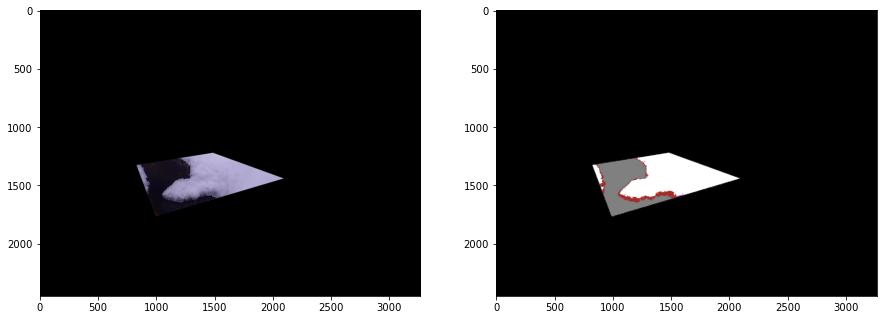

In [152]:
img, img_cp, point= display_predict_img(file)

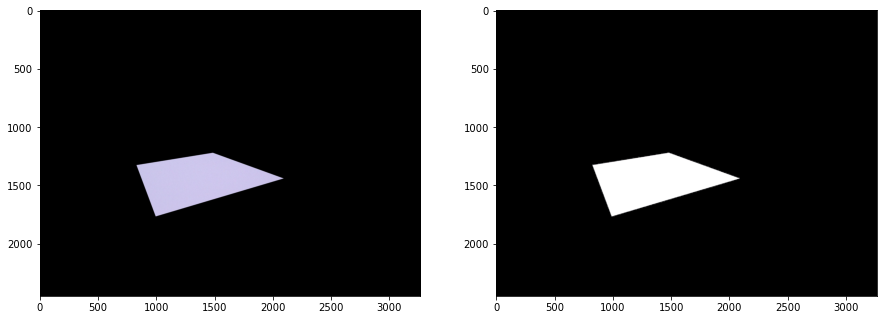

In [154]:
img_2_2, img_cp_2, point_2= display_predict_img("Hbwtr_w6_20190224_120101.JPG")

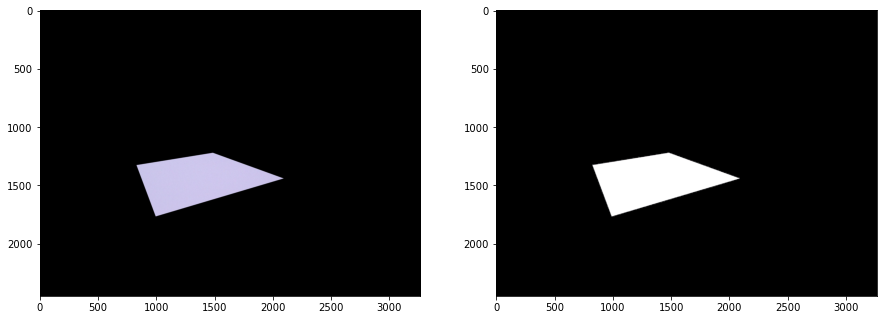

In [180]:
img_2_3, img_cp_3, point_3= display_predict_img("Hbwtr_w6_20190224_120101.JPG")

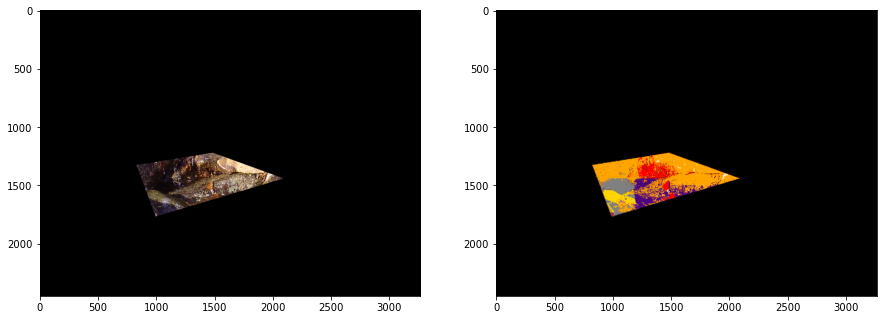

In [189]:
img_2_4, img_cp_4, point_4= display_predict_img("Hbwtr_w6_20191211_115931.JPG")

In [191]:
img_2_4, img_cp_4, point_4= display_predict_img("Hbwtr_w6_20191209_115937.JPG")

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

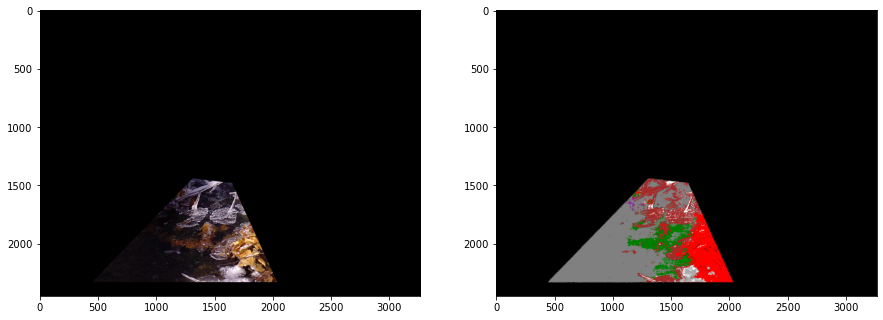

In [192]:
img_2_5, img_cp_5, point_5= display_predict_img("Hbwtr_w6_20181205_115912.JPG")

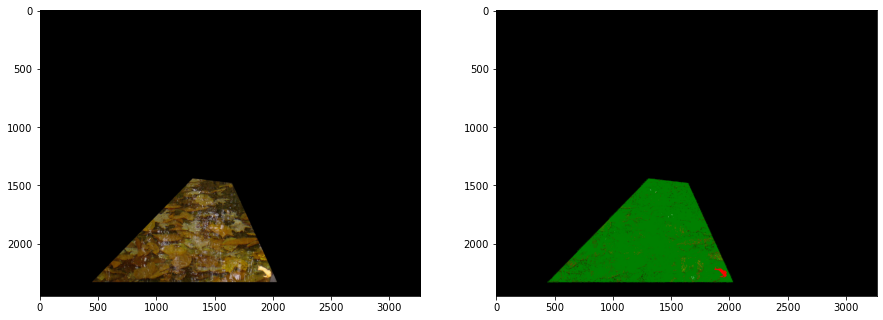

In [193]:
img_2_6, img_cp_6, point_6= display_predict_img("Hbwtr_w6_20181031_115902.JPG")

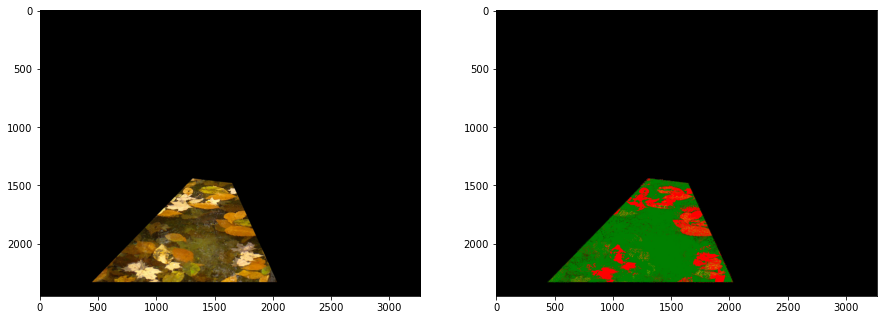

In [195]:
img_2_7, img_cp_7, point_7= display_predict_img("Hbwtr_w6_20181023_115928.JPG")

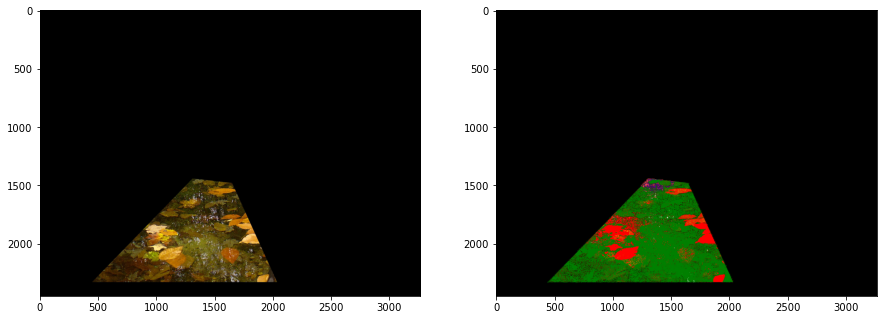

In [196]:
img_2_8, img_cp_8, point_8= display_predict_img("Hbwtr_w6_20181021_115934.JPG")

In [187]:
merged["temperature"].isnull().sum()

0

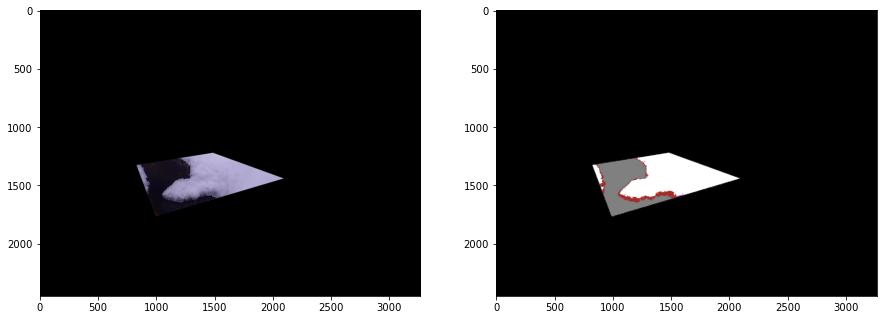

In [150]:
f, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img_cp)
f.set_figheight(15)
f.set_figwidth(15)


In [158]:
file = "Hbwtr_w6_20181018_120443.JPG"
img= np.asarray(Image.open("invert_"+file))
img_cp = img.copy()
ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
y_vals = ind[0]
x_vals = ind[1]
_= img[y_vals,x_vals,:]
r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
fl = m[m.orig_name==file][li].head(1)
point = pd.DataFrame({'x': x_vals,
 'y': y_vals,
 'R': r_vals,
 'G': g_vals,
 'B': b_vals,
})
# TODO cHANge
point['temperature']= 39
point['year']= fl.year.values[0]
point['week']= fl.week.values[0]
point['month']= fl.month.values[0]
point['season_autumn']= fl.season_autumn.values[0]
point['season_spring']= fl.season_spring.values[0]
point['season_winter']= fl.season_winter.values[0]

In [159]:
point

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
0,1298,1440,2,3,7,39,2018,42,10,1,0,0
1,1301,1440,2,1,15,39,2018,42,10,1,0,0
2,1302,1440,6,5,10,39,2018,42,10,1,0,0
3,1299,1441,7,7,17,39,2018,42,10,1,0,0
4,1303,1441,6,5,10,39,2018,42,10,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
688449,1967,2335,4,3,9,39,2018,42,10,1,0,0
688450,1968,2335,2,1,6,39,2018,42,10,1,0,0
688451,1969,2335,1,1,3,39,2018,42,10,1,0,0
688452,2025,2335,4,3,1,39,2018,42,10,1,0,0


In [177]:
# class_rgb = {'snow_o': "white",
#  'open_water_dark': "gray",
#  'ice_t': "brown",
#  'rock': "orange",
#  'leaf_fall': "green",
#  'snow_t': "blueviolet",
#  'leaf_sub': "yellow",
#  'other': "pink",
#  'ice_o': "darkgrey",
#  'leaf_green': "gold",
#  'open_water': "indigo",
#  'riffle': "magenta",
#  'open_water_green': "palegreen"}

In [170]:
# pr = model.predict(point)
# point["pred_class"] = pr
for ind, row in point.iterrows():
    x,y = row.x, row.y
    pred = row["pred_class"]
    newR, newG, newB=colors[class_rgb[pred]]
    img_cp[y,x,:] = [newR, newG,newB]

In [162]:
point.pred_class.value_counts()

leaf_sub            521290
leaf_fall           126755
open_water_green     39281
open_water            1123
riffle                   5
Name: pred_class, dtype: int64

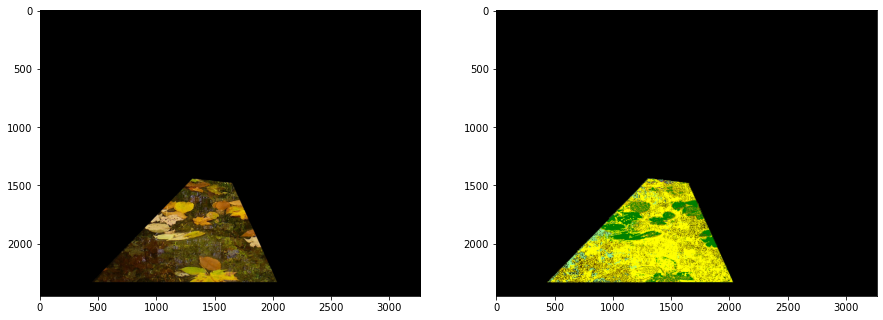

In [171]:
f, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img_cp)
f.set_figheight(15)
f.set_figwidth(15)

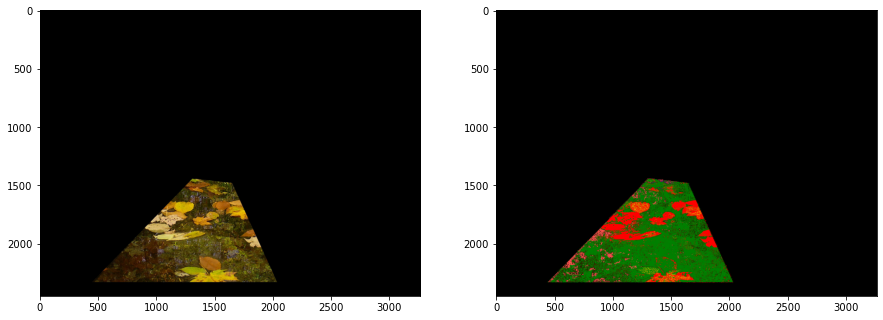

In [164]:
f, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[1].imshow(img_cp)
f.set_figheight(15)
f.set_figwidth(15)

In [ ]:
np.array(np.unique(pr, return_counts=True)).T

array([['open_water_dark', 78],
       ['snow_o', 22]], dtype=object)

In [84]:
m[m.orig_name==file]["class"].value_counts()


snow_o             11560
open_water_dark     4593
Name: class, dtype: int64

In [294]:
def predict_df(row):
    return model.predict(np.array(row.values).reshape(1, -1))[0]

In [298]:
sample_point["predicted_class"] = model.predict(sample_point)
sample_point

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter,predicted_class
678062,995,1364,202,198,235,33.0,2019,8,2,0,0,1,snow_o
678063,995,1365,203,199,236,33.0,2019,8,2,0,0,1,snow_o
678064,995,1366,204,200,237,33.0,2019,8,2,0,0,1,snow_o
678065,995,1367,205,201,238,33.0,2019,8,2,0,0,1,snow_o
678066,995,1368,205,201,238,33.0,2019,8,2,0,0,1,snow_o
...,...,...,...,...,...,...,...,...,...,...,...,...,...
687791,914,1396,202,195,236,33.0,2019,8,2,0,0,1,snow_o
687792,914,1397,202,195,236,33.0,2019,8,2,0,0,1,snow_o
687793,914,1398,202,195,236,33.0,2019,8,2,0,0,1,snow_o
687794,914,1399,202,195,236,33.0,2019,8,2,0,0,1,snow_o


In [334]:
img_copy = img.copy()

In [332]:
sample_point["predicted_class"].head().apply(lambda x: colors[class_rgb[x]])

678062    (255.0, 255.0, 255.0)
678063    (255.0, 255.0, 255.0)
678064    (255.0, 255.0, 255.0)
678065    (255.0, 255.0, 255.0)
678066    (255.0, 255.0, 255.0)
Name: predicted_class, dtype: object

In [437]:
img_copy[1364,995,:]

array([0, 0, 0], dtype=uint8)

In [534]:
img_copy[1364,995,:]

array([0, 0, 0], dtype=uint8)

In [532]:
def change_rgb(row):
    x,y = row.x, row.y
    if not ind[x,y]:
        return None
    r,g,b = colors[class_rgb[row["predicted_class"]]]
    img_copy[y,x:] = r,g,b
    return None

In [533]:
sample_point.apply(lambda x: change_rgb(x), axis=1)

678062    None
678063    None
678064    None
678065    None
678066    None
          ... 
687791    None
687792    None
687793    None
687794    None
687795    None
Length: 9734, dtype: object

In [481]:
(img[0,0,:] != [0,0,1]).any()

True

In [488]:
np.where( np.all(img == np.array([0,0,0]), axis=-1) )

(array([   0,    0,    0, ..., 2447, 2447, 2447]),
 array([   0,    1,    2, ..., 3261, 3262, 3263]))

In [543]:
sample_point.head()

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter,predicted_class
678062,995,1364,202,198,235,33.0,2019,8,2,0,0,1,snow_o
678063,995,1365,203,199,236,33.0,2019,8,2,0,0,1,snow_o
678064,995,1366,204,200,237,33.0,2019,8,2,0,0,1,snow_o
678065,995,1367,205,201,238,33.0,2019,8,2,0,0,1,snow_o
678066,995,1368,205,201,238,33.0,2019,8,2,0,0,1,snow_o


In [692]:
Color("red").rgb

(1.0, 0.0, 0.0)

In [698]:
img[ind].max()

255

In [716]:
img_copy[ind] = img[ind]

In [719]:
ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
y_vals = ind[0]
x_vals = ind[1]
_= img[y_vals,x_vals,:]
r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
fl = m[m.orig_name==file][li].head(1)
_

array([[ 6,  6,  8],
       [ 6,  6,  4],
       [ 6,  6,  4],
       ...,
       [11,  7,  8],
       [ 1,  1,  1],
       [ 2,  2,  2]], dtype=uint8)

In [720]:
img[10,500,:]

array([0, 0, 0], dtype=uint8)

In [721]:
y_vals

array([1216, 1216, 1216, ..., 1767, 1767, 1767])

In [722]:
x_vals

array([1464, 1469, 1472, ...,  991, 1014, 1015])

In [639]:
merged[merged.orig_name==file]["cll

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
678062,995,1364,202,198,235,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o


In [ ]:
fl

In [ ]:
2

In [724]:
point = pd.DataFrame({'x': x_vals,
 'y': y_vals,
 'R': r_vals,
 'G': g_vals,
 'B': b_vals,
})
point['temperature']= fl.temperature.values[0]
point['year']= fl.year.values[0]
point['week']= fl.week.values[0]
point['month']= fl.month.values[0]
point['season_autumn']= fl.season_autumn.values[0]
point['season_spring']= fl.season_spring.values[0]
point['season_winter']= fl.season_winter.values[0]

In [725]:
point.head()

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
0,1464,1216,6,6,8,35.0,2019,1,1,0,0,1
1,1469,1216,6,6,4,35.0,2019,1,1,0,0,1
2,1472,1216,6,6,4,35.0,2019,1,1,0,0,1
3,1473,1216,5,5,3,35.0,2019,1,1,0,0,1
4,1476,1216,5,5,7,35.0,2019,1,1,0,0,1


In [726]:
model.predict(point.head(2))

array(['open_water_dark', 'open_water_dark'], dtype=object)

In [613]:
point["predicted_class"] =  model.predict(point)

In [647]:
model.predict(point.head(10))

array(['open_water_dark', 'open_water_dark', 'open_water_dark',
       'open_water_dark', 'open_water_dark', 'open_water_dark',
       'open_water_dark', 'open_water_dark', 'open_water_dark',
       'open_water_dark'], dtype=object)

In [614]:
point

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter,predicted_class
0,1464,1216,7,7,9,33.0,2019,8,2,0,0,1,open_water_dark
1,1466,1216,3,3,3,33.0,2019,8,2,0,0,1,open_water_dark
2,1472,1216,7,6,12,33.0,2019,8,2,0,0,1,open_water_dark
3,1473,1216,2,1,7,33.0,2019,8,2,0,0,1,open_water_dark
4,1475,1216,2,1,7,33.0,2019,8,2,0,0,1,open_water_dark
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376567,1008,1767,3,3,3,33.0,2019,8,2,0,0,1,open_water_dark
376568,1009,1767,2,2,2,33.0,2019,8,2,0,0,1,open_water_dark
376569,1010,1767,1,1,1,33.0,2019,8,2,0,0,1,open_water_dark
376570,1012,1767,6,6,6,33.0,2019,8,2,0,0,1,open_water_dark


In [673]:
merged[merged["class"]=="snow_o"].orig_name.unique()

array(['Hbwtr_w6_20190101_115947.JPG', 'Hbwtr_w6_20190102_115944.JPG',
       'Hbwtr_w6_20190103_115941.JPG', 'Hbwtr_w6_20190104_120438.JPG',
       'Hbwtr_w6_20190105_115934.JPG', 'Hbwtr_w6_20190106_120431.JPG',
       'Hbwtr_w6_20190107_115928.JPG', 'Hbwtr_w6_20190108_120425.JPG',
       'Hbwtr_w6_20190109_115922.JPG', 'Hbwtr_w6_20190110_115918.JPG',
       'Hbwtr_w6_20190111_115915.JPG', 'Hbwtr_w6_20190112_115912.JPG',
       'Hbwtr_w6_20190113_115908.JPG', 'Hbwtr_w6_20190114_115905.JPG',
       'Hbwtr_w6_20190115_115902.JPG', 'Hbwtr_w6_20190116_115859.JPG',
       'Hbwtr_w6_20190117_115855.JPG', 'Hbwtr_w6_20190118_115852.JPG',
       'Hbwtr_w6_20190119_115849.JPG', 'Hbwtr_w6_20190120_115845.JPG',
       'Hbwtr_w6_20190121_115842.JPG', 'Hbwtr_w6_20190122_115839.JPG',
       'Hbwtr_w6_20190123_115835.JPG', 'Hbwtr_w6_20190124_115832.JPG',
       'Hbwtr_w6_20190125_115829.JPG', 'Hbwtr_w6_20190126_115826.JPG',
       'Hbwtr_w6_20190127_115822.JPG', 'Hbwtr_w6_20190128_115819.JPG',
      

In [630]:
merged[(merged.orig_name==file) & (merged.x==1008) & (merged.y<=1767)]

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class
678257,1008,1364,203,199,236,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678258,1008,1365,203,199,236,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678259,1008,1366,203,199,236,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678260,1008,1367,203,199,236,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678261,1008,1368,202,198,235,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678262,1008,1369,202,198,235,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678263,1008,1370,203,199,236,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678264,1008,1371,204,200,237,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678265,1008,1372,205,201,238,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o
678266,1008,1373,205,201,238,2019-02-24,12:01:01,Hbwtr_w6_20190224_120101.JPG,w6,33.0,snow_o


In [ ]:
def change_pixel(row):
    x,y = row.x, row.y
    if not ind[x,y]:
        return None
    r,g,b = colors[class_rgb[row["predicted_class"]]]
    img_copy[y,x:] = r,g,b
    return None

In [539]:
img_copy.shape

(2448, 3264, 3)

In [527]:
ind.shape, img.shape

((2448, 3264), (2448, 3264, 3))

In [530]:
ind[1500, 1500]

True

In [525]:
img[ind]

array([[ 7,  7,  9],
       [ 3,  3,  3],
       [ 7,  6, 12],
       ...,
       [ 1,  1,  1],
       [ 6,  6,  6],
       [10, 10, 10]], dtype=uint8)

In [519]:
img_copy[~ind].shape

(7613700, 3)

In [485]:
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        if not (img[y,x,:]==[0,0,0]).all():
            img_copy[y,x,:] = [255,255,0]
            

In [463]:
sample_point.apply(lambda x: change_rgb(x), axis=1);

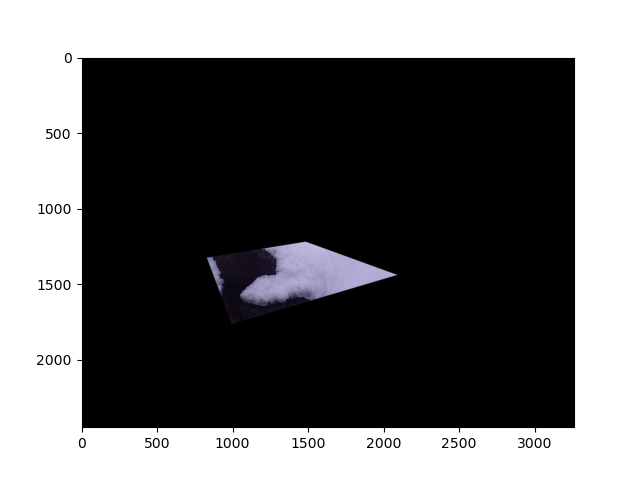

In [675]:
plt.imshow(img)
plt.show()

In [718]:
img_copy = np.zeros(img.shape).astype(np.uint8)

In [430]:
img_copy.shape, img.shape

((2448, 3264, 3), (2448, 3264, 3))

In [385]:
colors["red"]

(255.0, 0.0, 0.0)

In [434]:
for i in range(1000):
    img_copy[i, i,:] = 255,0,0

In [424]:
img_copy[:,:,:] = 255,255,0

In [406]:
_.x.describe()

count    9734.000000
mean     1306.530820
std       276.004379
min       892.000000
25%      1074.000000
50%      1259.000000
75%      1495.000000
max      1895.000000
Name: x, dtype: float64

In [413]:
_.y.describe()

count    9734.000000
mean     1461.088864
std       100.775230
min      1286.000000
25%      1388.000000
50%      1436.000000
75%      1539.000000
max      1658.000000
Name: y, dtype: float64

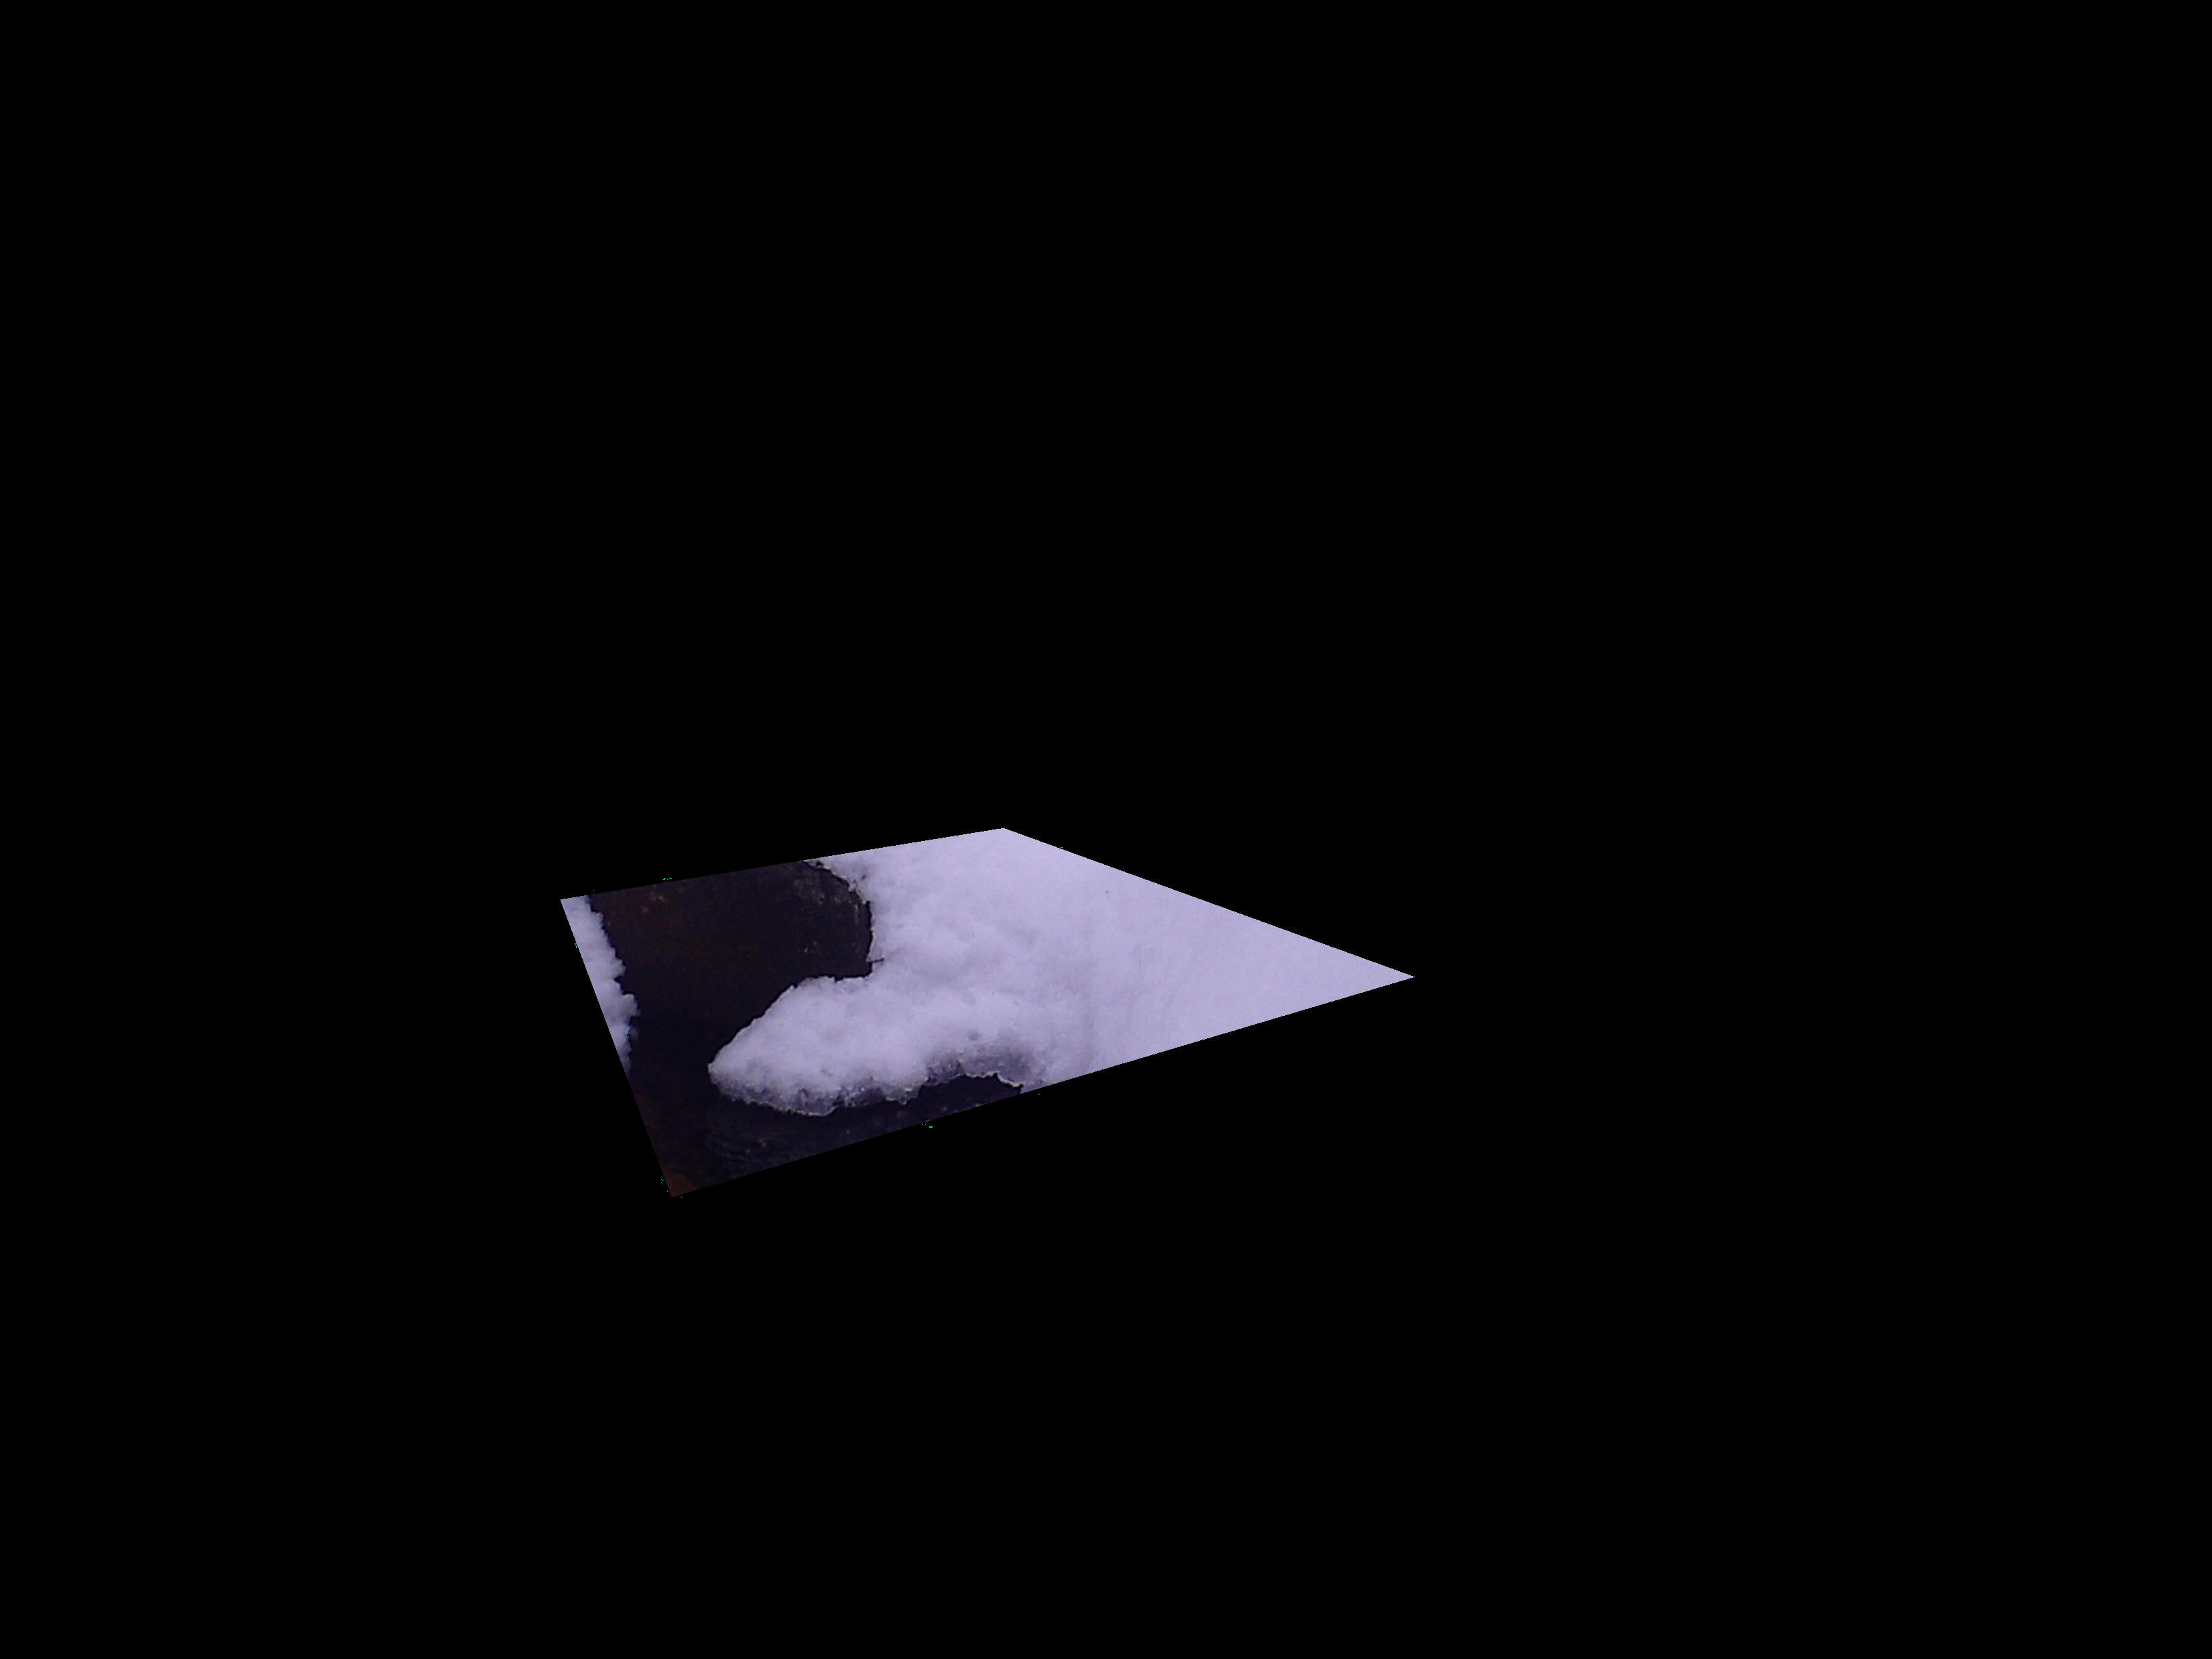

In [717]:
Image.fromarray(img_copy)

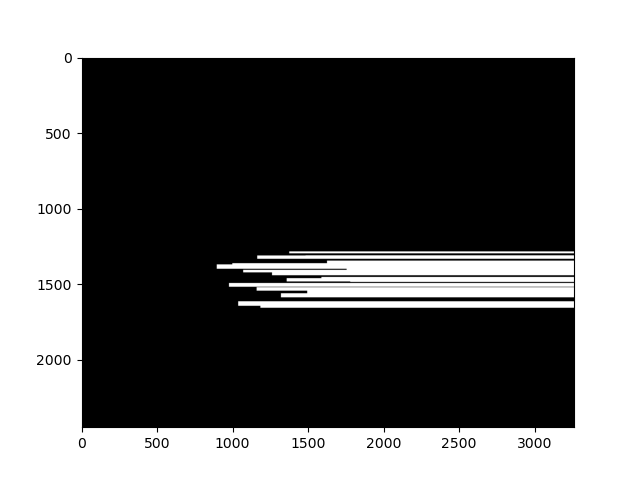

In [442]:
%matplotlib widget
plt.imshow(img_copy)
plt.show()

In [443]:
sample_point[sample_point.x==2621]

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter,predicted_class


In [333]:
sample_point.head()

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter,predicted_class
678062,995,1364,202,198,235,33.0,2019,8,2,0,0,1,snow_o
678063,995,1365,203,199,236,33.0,2019,8,2,0,0,1,snow_o
678064,995,1366,204,200,237,33.0,2019,8,2,0,0,1,snow_o
678065,995,1367,205,201,238,33.0,2019,8,2,0,0,1,snow_o
678066,995,1368,205,201,238,33.0,2019,8,2,0,0,1,snow_o


In [99]:
pip install colordict

Note: you may need to restart the kernel to use updated packages.


In [165]:
from colordict import ColorDict
colors = ColorDict()
list(colors.keys())

['aliceblue',
 'antiquewhite',
 'aqua',
 'aquamarine',
 'azure',
 'beige',
 'bisque',
 'black',
 'blanchedalmond',
 'blue',
 'blueviolet',
 'brown',
 'burlywood',
 'cadetblue',
 'chartreuse',
 'chocolate',
 'coral',
 'cornflowerblue',
 'cornsilk',
 'crimson',
 'cyan',
 'darkblue',
 'darkcyan',
 'darkgoldenrod',
 'darkgray',
 'darkgreen',
 'darkgrey',
 'darkkhaki',
 'darkmagenta',
 'darkolivegreen',
 'darkorange',
 'darkorchid',
 'darkred',
 'darksalmon',
 'darkseagreen',
 'darkslateblue',
 'darkslategray',
 'darkslategrey',
 'darkturquoise',
 'darkviolet',
 'deeppink',
 'deepskyblue',
 'dimgray',
 'dimgrey',
 'dodgerblue',
 'firebrick',
 'floralwhite',
 'forestgreen',
 'fuchsia',
 'gainsboro',
 'ghostwhite',
 'goldenrod',
 'gold',
 'gray',
 'green',
 'greenyellow',
 'grey',
 'honeydew',
 'hotpink',
 'indianred',
 'indigo',
 'ivory',
 'khaki',
 'lavenderblush',
 'lavender',
 'lawngreen',
 'lemonchiffon',
 'lightblue',
 'lightcoral',
 'lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 

In [307]:
from colour import Color
blue = Color("blue")
red = Color("blue")
green = Color("green")
orange = Color("orange")

In [300]:
import colorsys 
 
def HSVToRGB(h, s, v): 
 (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
 return (int(255*r), int(255*g), int(255*b)) 
 
def getDistinctColors(n): 
 huePartition = 1.0 / (n + 1) 
 return (HSVToRGB(huePartition * value, 1.0, 1.0) for value in range(0, n)) 

In [302]:
getDistinctColors(2)[0]

TypeError: 'generator' object is not subscriptable

In [266]:
temp,year, week, month, aut, spr, win = _.iloc[0][5:]
for ind,row in _.iterrows():
    new_x, new_y = row.x, row.y
    predict_class = model.predict(row.reshape(1, -1))
    print(predict_class)
    

AttributeError: 'Series' object has no attribute 'reshape'

In [230]:
test_sample.columns

Index(['x', 'y', 'R', 'G', 'B', 'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter', 'class'],
      dtype='object')

In [ ]:
{'x': 0,
 'y': 1,
 'R': 2,
 'G': 3,
 'B': 4,
 'date': 5,
 'time': 6,
 'orig_name': 7,
 'watershed': 8,
 'temperature': 9,
 'year': 11,
 'week': 12,
 'month': 13,
 'season': 14,
 'season_autumn': 15,
 'season_spring': 16,
 'season_winter': 17}

In [146]:
test_sample.columns

Index(['x', 'y', 'R', 'G', 'B', 'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter', 'class'],
      dtype='object')

In [165]:
test = test_sample_copy.copy()
li = ['x', 'y', 'R', 'G', 'B', 'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']
_ = test.head(0)
_ = _[li]
date_ind = test[test.orig_name==file].head(1)[li]
_.iloc[len(_)] = [date_ind.values]
_

IndexError: iloc cannot enlarge its target object

In [ ]:
_.loc[len(_),:] = date_ind.values


In [172]:
_.loc[0,:] = 0

In [175]:
_

,x,y,R,G,B,temperature,year,week,month,season_autumn,season_spring,season_winter
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN


ERROR! Session/line number was not unique in database. History logging moved to new session 2


In [161]:
date_ind.values

array([[995, 1364, 202, 198, 235, 33.0, 2019, 8, 2, 0.0, 0.0, 1.0]],
      dtype=object)

In [134]:
test_sample_copy.head()

,x,y,R,G,B,date,time,orig_name,watershed,temperature,class,year,week,month,season,season_autumn,season_spring,season_winter
84146,974,1368,55,36,42,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84289,982,1375,50,31,35,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84432,990,1382,50,35,40,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84575,1065,1355,56,33,43,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0
84718,1070,1363,49,36,46,2019-01-07,2022-07-18 11:59:28,Hbwtr_w6_20190107_115928.JPG,w6,21.0,open_water_dark,2019,2,1,winter,0.0,0.0,1.0


In [81]:
dict(zip(range(12),merged["class"].unique()))

{0: 'snow_o',
 1: 'open_water_dark',
 2: 'ice_t',
 3: 'rock',
 4: 'leaf_fall',
 5: 'snow_t',
 6: nan,
 7: 'leaf_sub',
 8: 'other',
 9: 'ice_o',
 10: 'leaf_green',
 11: 'open_water'}

array(['snow_o'], dtype=object)

In [ ]:
x	y	R	G	B	temperature	year	week	month	season_autumn	season_spring	season_winter

In [46]:
test_sample_copy[test_sample_copy.orig_name == "Hbwtr_w6_20190224_120101.JPG"].iloc[0].values[9:]


array([33.0, 'snow_o', 2019, 8, 2, 'winter', 0.0, 0.0, 1.0], dtype=object)

In [13]:
c = img.copy()
c.shape

(2448, 3264, 3)

In [11]:
img.shape

(2448, 3264, 3)

In [12]:
2448* 3264 *3

23970816

In [8]:
plt.imshow(img[img!=0].squeeze().permute(1,2,0))

TypeError: Invalid shape (1145046,) for image data

In [133]:
test_sample_copy.loc[84146,"orig_name"]

'Hbwtr_w6_20190107_115928.JPG'

In [144]:
print(test_sample_copy.orig_name.unique())

['Hbwtr_w6_20190107_115928.JPG' 'Hbwtr_w6_20190108_120425.JPG'
 'Hbwtr_w6_20190110_115918.JPG' 'Hbwtr_w6_20190111_115915.JPG'
 'Hbwtr_w6_20190112_115912.JPG' 'Hbwtr_w6_20190113_115908.JPG'
 'Hbwtr_w6_20190114_115905.JPG' 'Hbwtr_w6_20190115_115902.JPG'
 'Hbwtr_w6_20190116_115859.JPG' 'Hbwtr_w6_20190117_115855.JPG'
 'Hbwtr_w6_20190118_115852.JPG' 'Hbwtr_w6_20190119_115849.JPG'
 'Hbwtr_w6_20190120_115845.JPG' 'Hbwtr_w6_20190122_115839.JPG'
 'Hbwtr_w6_20190123_115835.JPG' 'Hbwtr_w6_20190125_115829.JPG'
 'Hbwtr_w6_20190126_115826.JPG' 'Hbwtr_w6_20190127_115822.JPG'
 'Hbwtr_w6_20190128_115819.JPG' 'Hbwtr_w6_20190129_115816.JPG'
 'Hbwtr_w6_20190130_120312.JPG' 'Hbwtr_w6_20190131_115809.JPG'
 'Hbwtr_w6_20190201_115806.JPG' 'Hbwtr_w6_20190202_120503.JPG'
 'Hbwtr_w6_20190203_120000.JPG' 'Hbwtr_w6_20190204_115957.JPG'
 'Hbwtr_w6_20190205_120052.JPG' 'Hbwtr_w6_20190206_120052.JPG'
 'Hbwtr_w6_20190207_120052.JPG' 'Hbwtr_w6_20190208_120053.JPG'
 'Hbwtr_w6_20190209_120053.JPG' 'Hbwtr_w6_20190210_1200